In [1]:
from typing import List, Tuple, Optional, Mapping
import pandas as pd
import numpy as np
from collections import defaultdict
import statsmodels.api as sm
import matplotlib.pyplot as plt

import os
sys.path.append(os.path.relpath("../performance_evaluation/"))
from performance_utils import performance_for_df, NAV_df_plot
from predictors import *

%matplotlib inline

/Users/landytang/opt/anaconda3/envs/my_tf_env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
NAV_df_plot

<function performance_utils.NAV_df_plot(NAV_df, high_mark_cols, low_mark_cols, labels=[], grid=True, fig_path=None)>

In [3]:
class IndicesSelector():
    def __init__(self):
        pass

    def select(self, df: Optional[pd.DataFrame] = None) -> List[str]:
        price_df = pd.read_csv('../data/total_ret_idx_df.csv')
        return price_df['ETF_Ticker'].unique()

In [4]:
class PairsSelector():
    def __init__(self):
        pass

    def select(self, df: Optional[pd.DataFrame] = None) -> List[List[str]]:
        training_df = pd.read_csv('../data/TrainingSet.csv')
        pairs = [[p.split("_")[0], p.split("_")[1]] for p in training_df["Ticker_Pair"].unique()]
        return pairs

In [5]:
class SignalGenerator():
    def __init__(self):
        pass

    def pair_sig_to_asset_sig(self, price_df: pd.DataFrame, signal_df: pd.DataFrame, cost=100.0):
        idx = signal_df.index.map(lambda x: price_df.index.get_loc(x) + 1)
        if idx[-1] >= len(price_df.index):
            signal_df = signal_df.iloc[:-1]
            idx = idx[:-1]
        signal_df.index = price_df.index[idx]
        assets = price_df.columns
        strategy_asset = [[0] * len(assets)]
        current_cost = [cost]
        
        def process_signal(x):
            if not x['pair']:
                strategy_asset.append([0] * len(assets))
                return
            buy_symbol = x['pair'].split('_')[0]
            sell_symbol = x['pair'].split('_')[1]
            chg_cost = np.array(strategy_asset[-1]) * np.array(price_df.loc[x.name])
            chg_cost[np.isnan(chg_cost)] = 0
            current_cost[-1] = current_cost[-1] - np.sum(chg_cost)
            buy_px = price_df.loc[x.name][buy_symbol]
            buy_qty = current_cost[-1] / buy_px
            sell_px = price_df.loc[x.name][sell_symbol]
            sell_qty = current_cost[-1] / sell_px
            current_cost.append(current_cost[-1])
            if x['side'] == True:
                strategy_asset[-1][assets.get_loc(buy_symbol)] += buy_qty
                strategy_asset[-1][assets.get_loc(sell_symbol)] -= sell_qty 
                strategy_asset.append([0] * len(assets))
                strategy_asset[-1][assets.get_loc(buy_symbol)] -= buy_qty 
                strategy_asset[-1][assets.get_loc(sell_symbol)] += sell_qty 
            elif x['side'] == False:
                strategy_asset[-1][assets.get_loc(buy_symbol)] -= buy_qty 
                strategy_asset[-1][assets.get_loc(sell_symbol)] += sell_qty 
                strategy_asset.append([0] * len(assets))
                strategy_asset[-1][assets.get_loc(buy_symbol)] += buy_qty 
                strategy_asset[-1][assets.get_loc(sell_symbol)] -= sell_qty 
            else:
                strategy_asset.append([0] * len(assets))

        signal_df.iloc[:-1].apply(process_signal, axis=1) 
        return pd.DataFrame(strategy_asset, columns=assets, index=signal_df.index)


    def generate(self, pairs: List[str], price_df: pd.DataFrame, \
                 predict_df: pd.DataFrame, params: Optional[Mapping] = None)\
                 -> List[pd.DataFrame]:
        pass

In [6]:
class PercentileCurrent(SignalGenerator):
    def __init__(self):
        pass

    def generate(self, pairs: List[str], price_df: pd.DataFrame, \
                 predict_df: pd.DataFrame, params: Optional[Mapping] = None)\
                 -> List[pd.DataFrame]:
        if params is None:
            params = {
                'holding_period': 20,
                'distribution_period': 60,
                'training_period': 2769,
                'cost': 100.,
                'periodic': False
            }
        holding_period = params["holding_period"]
        distribution_period = params["distribution_period"]
        training_period = params["training_period"]
        cost = params["cost"]
        periodic = params["periodic"]

        if not periodic:

            training_df = price_df.iloc[:training_period]
            
            ols_coeffs = {}
            for pair in pairs:
                df = training_df[[pair[0],pair[1]]].dropna()
                X = df[pair[0]]
                y = df[pair[1]]
                X = sm.add_constant(X)

                model = sm.OLS(y, X)
                results = model.fit()
                ols_coeffs[(pair[0], pair[1])] = results.params.iloc[0], results.params.iloc[1]
        
            signal_df = pd.DataFrame()
            for pair in pairs:
                col = '_'.join(pair)
                const_coeff, beta = ols_coeffs[(pair[0], pair[1])]
                signal_df[col] = price_df[pair[0]] - (price_df[pair[1]] * beta + const_coeff)
            signal_df = signal_df.rolling(distribution_period).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1]) - 0.5
            signal_df = signal_df.iloc[::holding_period, :]
        else:
            signal_raw = defaultdict(list)
            for i in range(0, len(price_df), holding_period):
                if i < distribution_period or i < training_period:
                    for pair in pairs:
                        col = '_'.join(pair)
                        signal_raw[col].append(None)
                    continue
                for pair in pairs:
                    col = '_'.join(pair)
                    df = price_df.iloc[i - training_period:i][[pair[0],pair[1]]].dropna()
                    X = df[pair[0]]
                    y = df[pair[1]]
                    if len(y) < distribution_period * 0.3:
                        signal_raw[col].append(None)
                        continue
                    X = sm.add_constant(X)
                    model = sm.OLS(y, X)
                    results = model.fit()
                
                    const_coeff, beta = results.params.iloc[0], results.params.iloc[1]
                    spread = price_df.iloc[i-distribution_period+1:i+1][pair[0]] - (price_df.iloc[i-distribution_period+1:i+1][pair[1]] * beta + const_coeff)
                    signal_raw[col].append(spread.rank(pct=True).iloc[-1] - 0.5)
            signal_df = pd.DataFrame(signal_raw, index=price_df.iloc[::holding_period, :].index)

        signal_df['pair'] = np.abs(signal_df).idxmax(axis=1)
        signal_df['pair'].fillna(value='', inplace=True)
        signal_df['side'] = signal_df.apply(lambda x: x[x["pair"]] < 0 if x["pair"] else None, axis=1)
        pair_sig = self.pair_sig_to_asset_sig(price_df, signal_df, cost)
        asset_sig = signal_df[['pair', 'side']]
        return pair_sig, asset_sig
    

In [7]:
class MostSpreadReturnPredict(SignalGenerator):
    def __init__(self):
        pass

    def generate(self, pairs: List[str], price_df: pd.DataFrame, \
                 predict_df: pd.DataFrame, params: Optional[Mapping] = None)\
                 -> List[pd.DataFrame]:

        if params is None:
            params = {
                'holding_period': 1,
                'cost': 100.
            }
        cost = params["cost"]
        holding_period = params["holding_period"]
        signal_df = pd.DataFrame()
        predict_df = predict_df.reset_index()
        signal_df = predict_df.iloc[predict_df.groupby('Date')['pred_spread'].agg(lambda x: np.abs(x).idxmax())]
        signal_df.set_index("Date", inplace=True)
        signal_df.index = pd.to_datetime(signal_df.index)
        signal_df = signal_df.iloc[::holding_period, :]
        signal_df['side'] = signal_df['pred_spread'] > 0
        signal_df = signal_df
        asset_sig = self.pair_sig_to_asset_sig(price_df, signal_df, cost)
        return asset_sig, signal_df[['pair', 'side']]

In [8]:
class PairTradingPipeline():
    """
    @param price_df DataFrame with symbol columns and price values
    @param training_ratio ratio of the subset of the price_df to be used to select paris
    """
    def __init__(self, price_df: pd.DataFrame, training_ratio: float=0.5):
        self.test_date = '2017-01-01'
        self.price_df = price_df.copy()
        training_idx = int(len(price_df) * training_ratio)
        self.index_selection_df = self.price_df[:training_idx]
        self.pair_selection_df = self.price_df[training_idx:]
        self.selected_indices = None
        self.indicies_selector = IndicesSelector()
        self.pairs_selector = PairsSelector()
        self.selected_pairs = None
        self.predictors = {
            'linear': LinearPredictor(),
            'elastic': ElasticNetPredictor(),
            'XGB': XGBPredictor(),
            'lstm': LSTMPredictor()
        }
        self.predict_result = defaultdict(dict)
        self.signal_generator = {
            'percentile_current': PercentileCurrent(),
            'most_spread_rtn': MostSpreadReturnPredict()
        }
        self.signal_result = defaultdict(dict)

    def select_indicies(self) -> List[str]:
        self.selected_indices = self.indicies_selector.select(self.index_selection_df)
        return self.selected_indices

    def select_pairs(self) -> List[List[str]]:
        if self.selected_indices is None:
            self.select_indicies()
        # self.selected_pairs = self.pairs_selector.select(self.index_selection_df[[self.selected_indices]])
        self.selected_pairs = self.pairs_selector.select()
        return self.selected_pairs 

    def predict(self, predictor: str, pair: List[str], params: Optional[Mapping] = None, periodic: Optional[bool] = False):
        period = params['pred_period'] if params and params['pred_period'] else 'D'
        if periodic:
            # self.predict_result[predictor] = self.predictors[predictor].periodic_train_predict(self.pair_selection_df[pair])
            self.predict_result[period][predictor+'_periodic'] = \
                self.predictors[predictor].periodic_train_predict(params=params)
            return self.predict_result[period][predictor+'_periodic']
        else:
            # self.predictors[predictor].train(self.pair_selection_df)
            # self.predict_result[predictor] = self.predictors[predictor].predict(self.pair_selection_df[pair])
            self.predict_result[period][predictor] = \
                self.predictors[predictor].predict(params=params)
        return self.predict_result[period][predictor]
    
    def create_signal(self, signalGenerator: str, predict_df: pd.DataFrame, price_df: pd.DataFrame, params: Optional[Mapping] = None):
        if self.selected_pairs is None:
            self.select_pairs()
        return self.signal_generator[signalGenerator].generate(self.selected_pairs, price_df, predict_df, params)
    
    def generate_portfolio(self, trade_df: pd.DataFrame, price_df: pd.DataFrame):
        
        etf_pos = (trade_df.reindex(price_df.index).fillna(0).cumsum() * price_df.fillna(0)).sum(axis = 1)
        port_df = pd.DataFrame(etf_pos, columns=['etf_pos'])
        port_df['cash_pos'] = (-trade_df * price_df).sum(axis = 1).cumsum()
        port_df['total_pos'] = etf_pos + port_df['cash_pos']
        return port_df

    def calc_port_return(self, port_df: pd.DataFrame, trade_df: pd.DataFrame, cost=100.):
        etf_ret = port_df[['etf_pos']].copy()
        etf_ret['base'] = etf_ret['etf_pos'].shift()
        per_period_ret = (port_df['cash_pos'] - port_df['cash_pos'].shift()).loc[trade_df.index]
        etf_ret['etf_pos'].loc[trade_df.index] = per_period_ret
        per_period_ret /= cost
        etf_ret += cost
        return (etf_ret['etf_pos'] / etf_ret['base'] - 1), per_period_ret

    def calc_port_return_fr_lev(self, port_df: pd.DataFrame, trade_df: pd.DataFrame, cost=100.):
        etf_ret = port_df['total_pos'].copy() + cost
        period_ret = etf_ret.loc[trade_df.index]
        return (etf_ret / etf_ret.shift() - 1), \
               (period_ret / period_ret.shift() - 1)

    def show_port_results(self, model_name, pair_trade_df, trade_df, price_df):

        plot_df = pair_trade_df.pivot_table(values='side', columns='pair', index=pair_trade_df.index)
        plot_df[plot_df == 0] = -1
        plot_df.plot(style='.', figsize=(9, 3), title=model_name + ' Pair Traded', \
                     ylabel='Side (buy: 1, sell: -1)', xlabel='Pair')
        plt.show()
        
        port_df = self.generate_portfolio(trade_df, price_df)
        port_df['total_pos'].plot(figsize=(9, 3), title=model_name + ' Porfolio Value')
        plt.show()

        daily_ret_df, per_period_ret_df = self.calc_port_return_fr_lev(port_df, trade_df)
        daily_ret_df.plot(figsize=(9, 3), title=model_name + ' Daily Return')
        plt.show()

        per_period_ret_df.plot(figsize=(9, 3), title=model_name + ' Per Trading Period Return')
        plt.show()

        return port_df, daily_ret_df, per_period_ret_df

    def run(self, model_name: str, periodic: Optional[bool] = False, params: Optional[Mapping] = None, 
            currentMode: Optional[bool] = False):
        period = params['pred_period'] if params and params['pred_period'] else 'D'
        price_pivot_df = self.price_df.pivot_table("Total Return", ["Date"], columns="ETF_Ticker")
        price_pivot_df.index = pd.to_datetime(price_pivot_df.index)
        price_pivot_in_df = price_pivot_df.loc[:self.test_date]
        price_pivot_out_df = price_pivot_df.loc[self.test_date:]

        if not currentMode:
            pred_df = self.predict(model_name, pairs, periodic=periodic, params=params)
            in_pred_df = pred_df.loc[pred_df['Date'] < self.test_date]
            out_pred_df = pred_df.loc[pred_df['Date'] >= self.test_date]
            in_trade_df, in_pair_trade_df = self.create_signal('most_spread_rtn', in_pred_df, price_pivot_in_df, params)
            out_trade_df, out_pair_trade_df = self.create_signal('most_spread_rtn', out_pred_df, price_pivot_out_df, params)

        else:
            trade_df, pair_trade_df = self.create_signal(model_name, None, price_pivot_df, params)
            in_trade_df = trade_df.loc[:self.test_date]
            out_trade_df = trade_df.loc[self.test_date:]
            in_pair_trade_df = pair_trade_df.loc[:self.test_date]
            out_pair_trade_df = pair_trade_df.loc[self.test_date:]
        
        in_port_df, in_daily_ret_df, in_per_period_ret_df = self.show_port_results(model_name + " in-sample", \
            in_pair_trade_df, in_trade_df, price_pivot_in_df)
        out_port_df, out_daily_ret_df, out_per_period_ret_df = self.show_port_results(model_name + " out-sample", \
            out_pair_trade_df, out_trade_df, price_pivot_out_df)
        self.signal_result[period][model_name+('_periodic' if periodic else '')] = \
            [[in_port_df, in_daily_ret_df, in_per_period_ret_df], [out_port_df, out_daily_ret_df, out_per_period_ret_df]]


In [9]:
params = {
        'pred_period': 'W',
        'cost' : 100,
        'holding_period': 21,
    }

In [10]:
# pred_df = pipeline.predict('lstm', pairs, periodic=False, params=params)
# in_pred_df = pred_df.loc[pred_df['Date'] < pipeline.test_date]
# out_pred_df = pred_df.loc[pred_df['Date'] >= pipeline.test_date]
# in_trade_df, in_pair_trade_df = pipeline.create_signal('most_spread_rtn', in_pred_df, params)
# out_trade_df, out_pair_trade_df = pipeline.create_signal('most_spread_rtn', out_pred_df, params)

In [11]:
price_df = pd.read_csv('../data/total_ret_idx_df.csv')
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_pivot_df = price_df.pivot_table("Total Return", ["Date"], columns="ETF_Ticker")
price_pivot_df.index =pd.to_datetime(price_pivot_df.index)

training_df = pd.read_csv('../data/TrainingSet.csv')
training_df

pipeline = PairTradingPipeline(price_df)
pairs = pipeline.select_pairs()

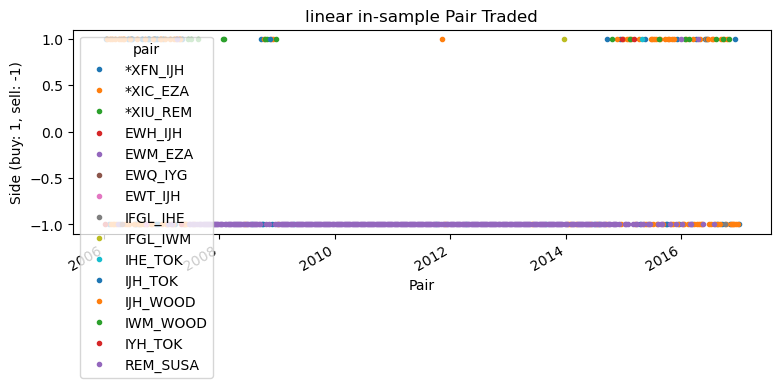

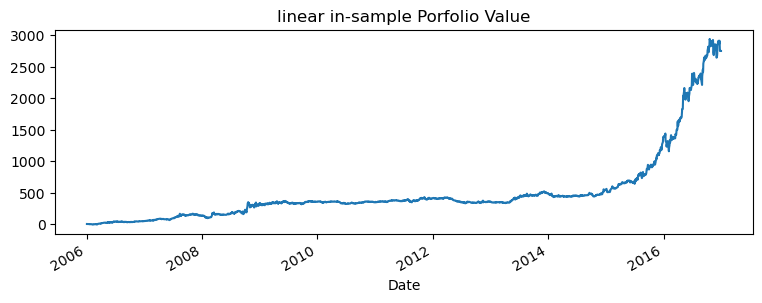

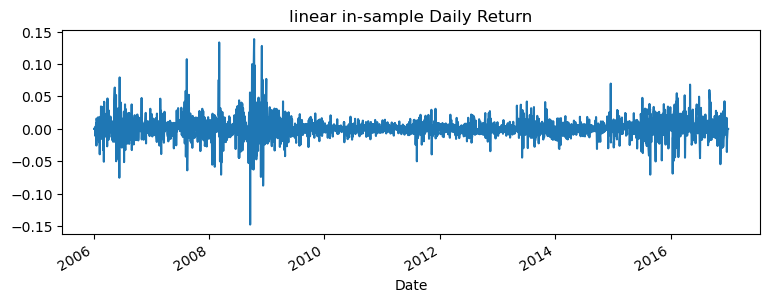

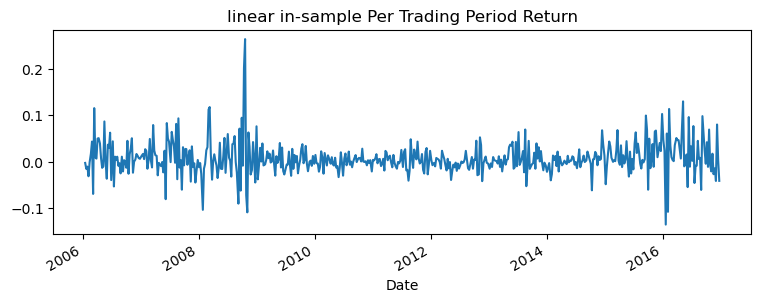

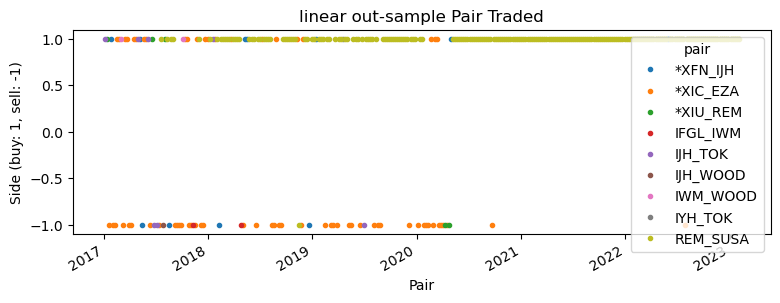

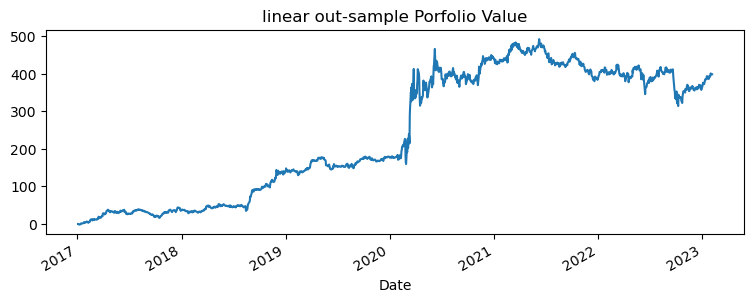

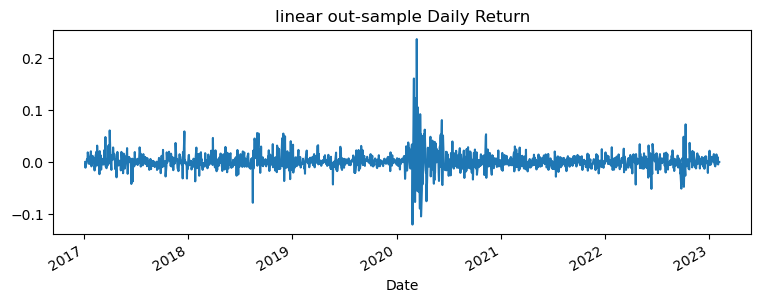

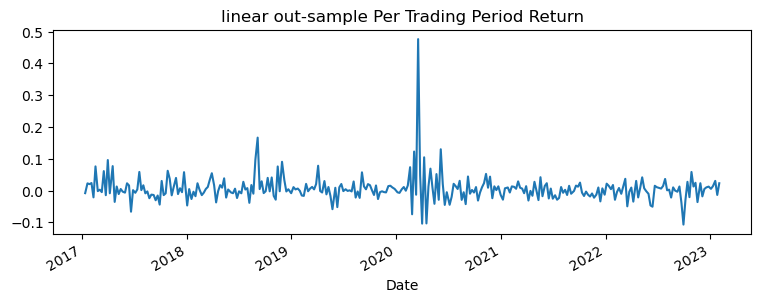

In [12]:
pipeline.run('linear', params = {
                'pred_period': 'D',
                'cost' : 100,
                'holding_period': 5,
            })

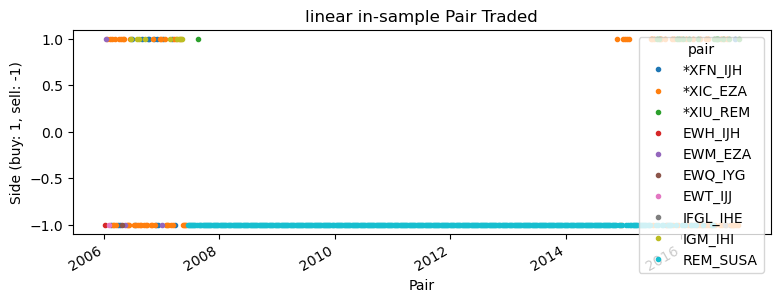

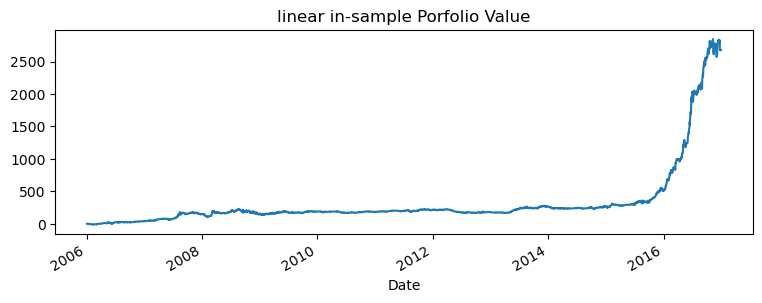

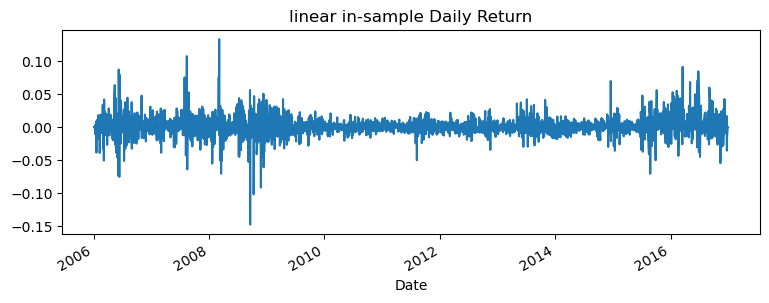

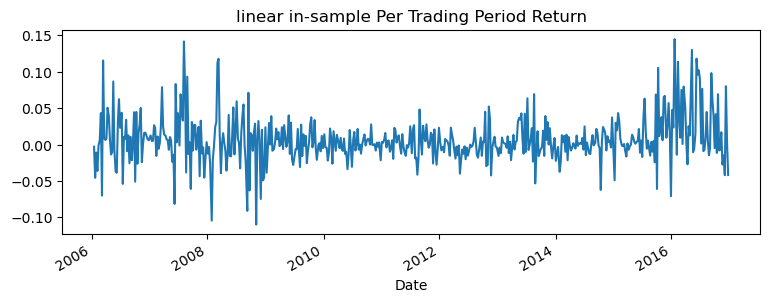

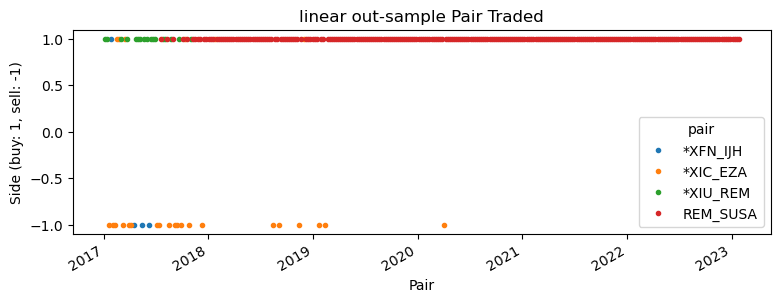

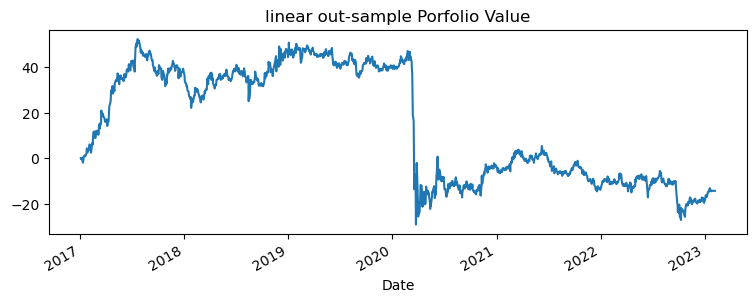

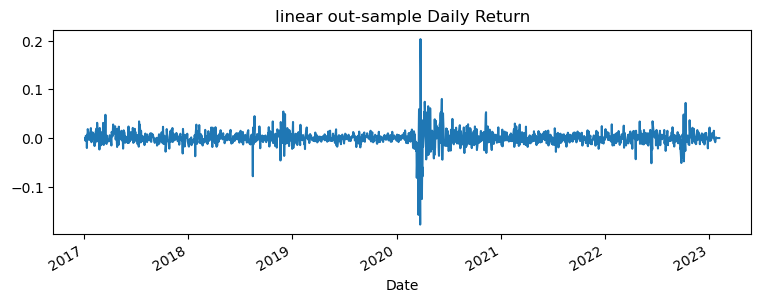

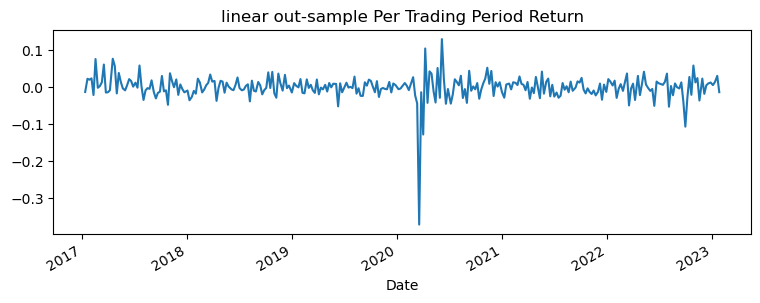

In [13]:
pipeline.run('linear', params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

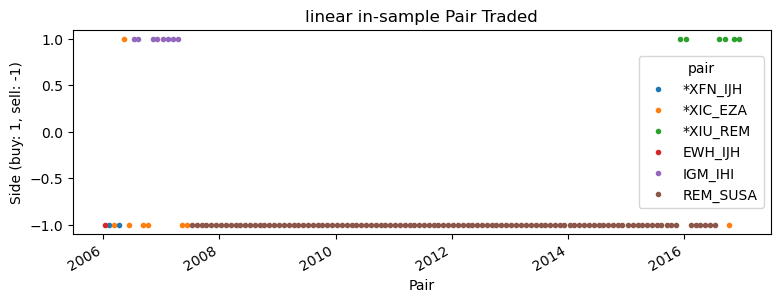

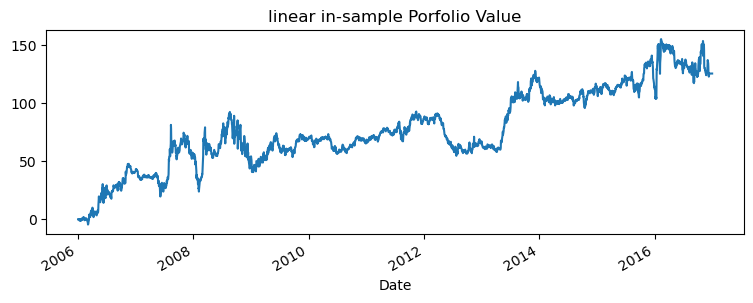

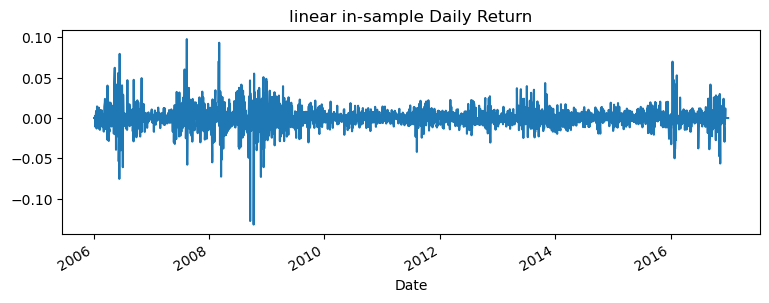

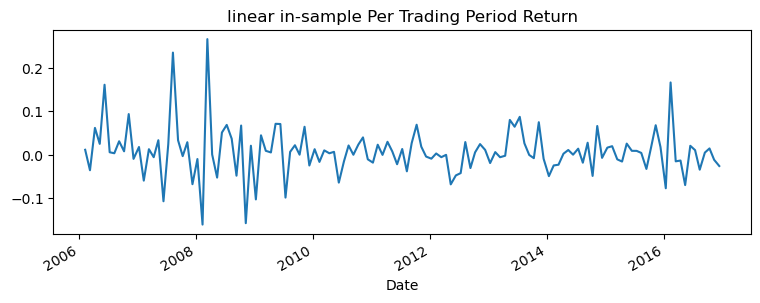

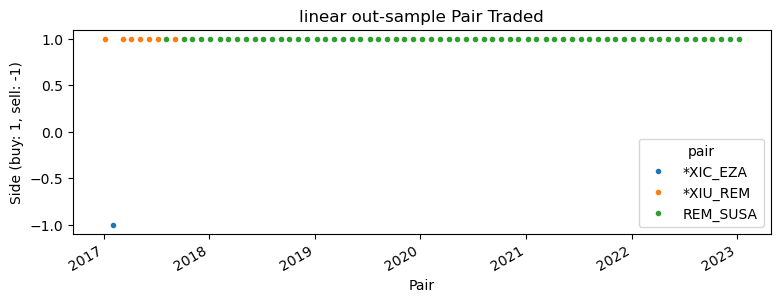

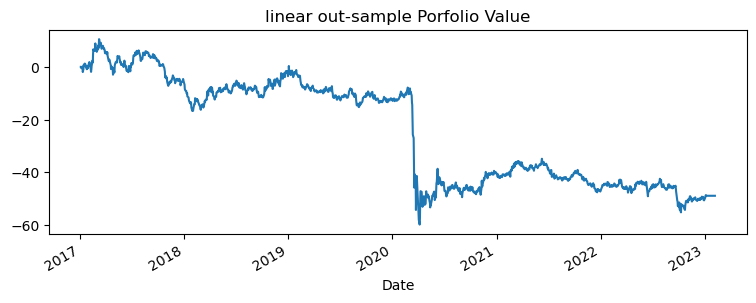

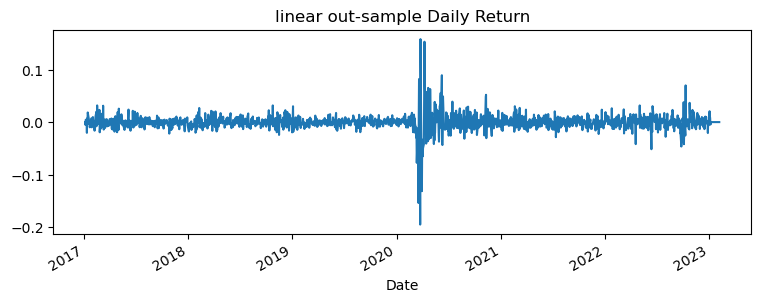

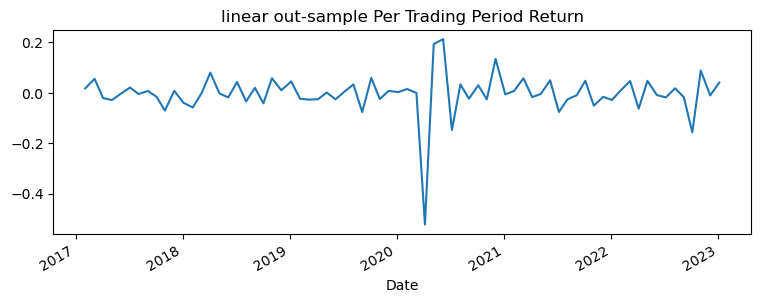

In [14]:
pipeline.run('linear', params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

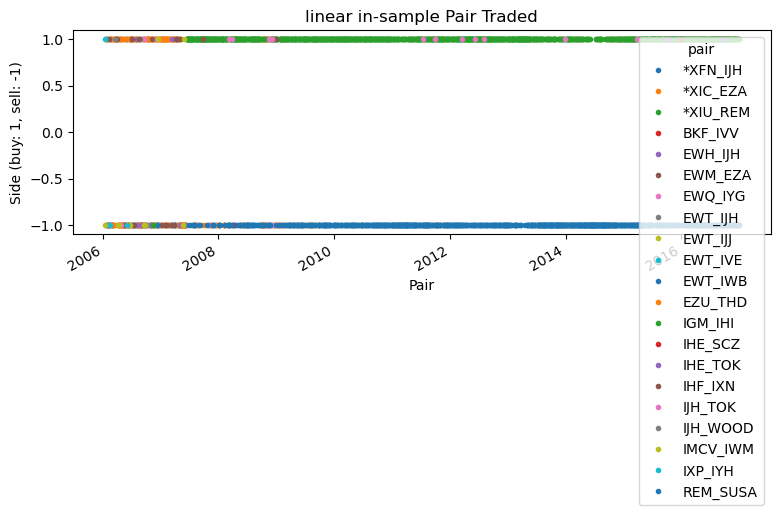

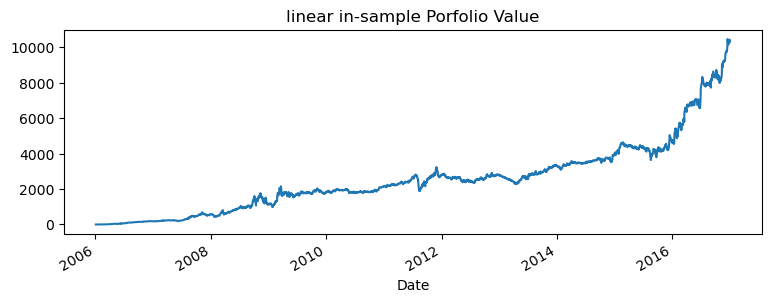

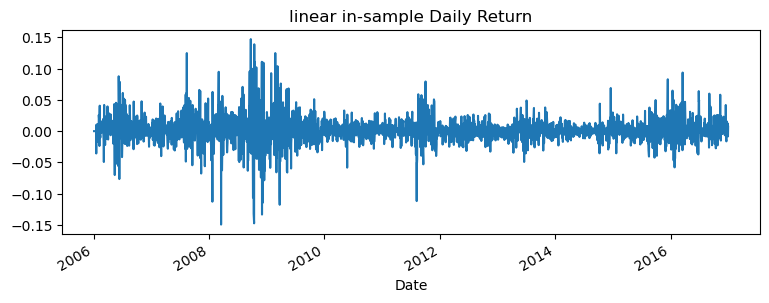

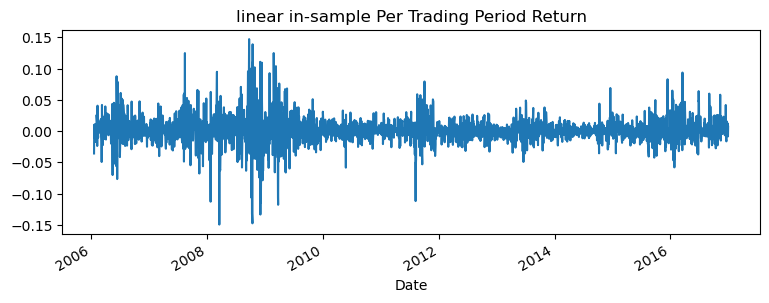

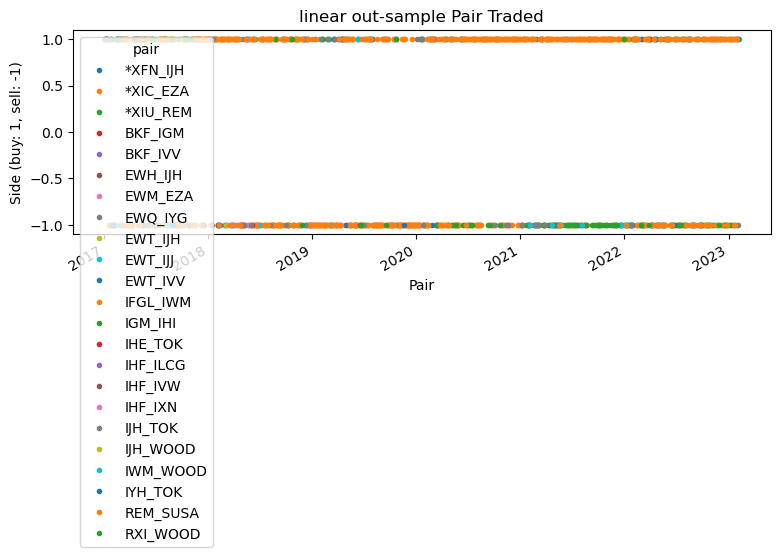

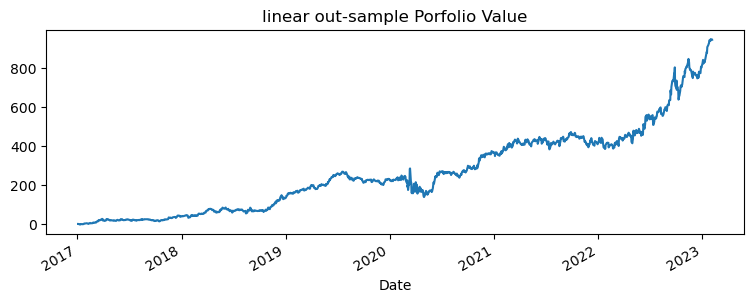

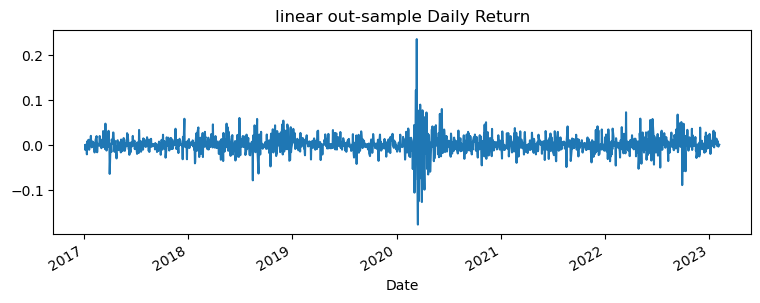

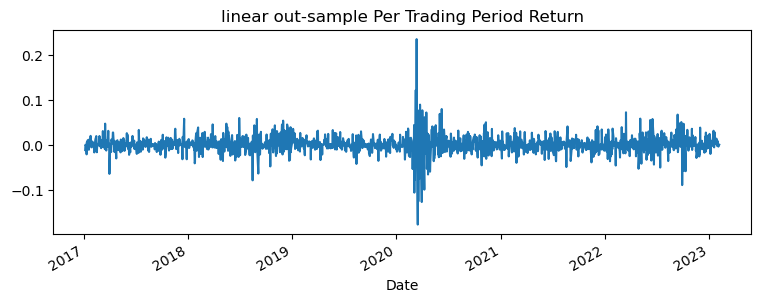

In [15]:
pipeline.run('linear', periodic=True, params = {
                'pred_period': 'D',
                'cost' : 100,
                'holding_period': 1,
            })

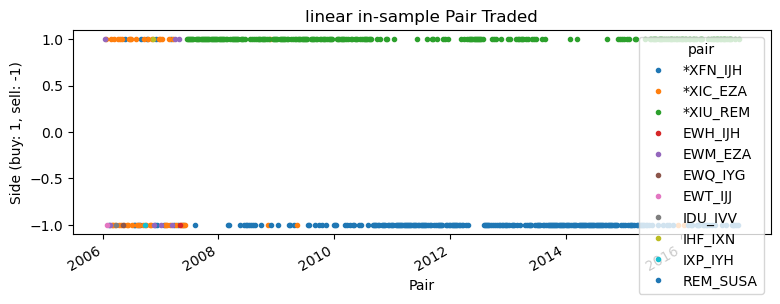

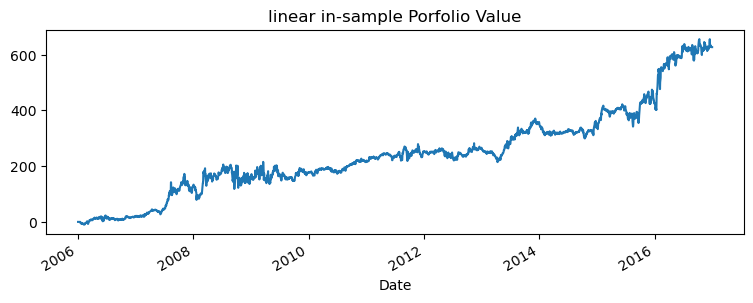

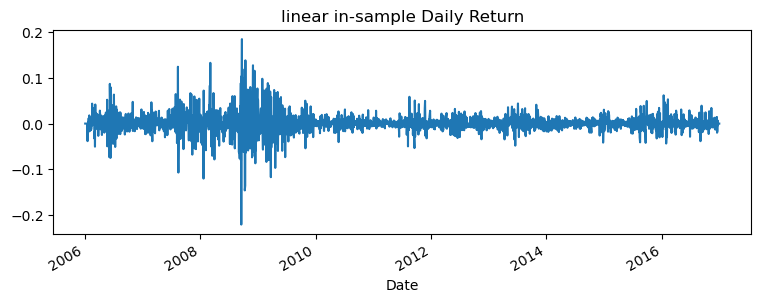

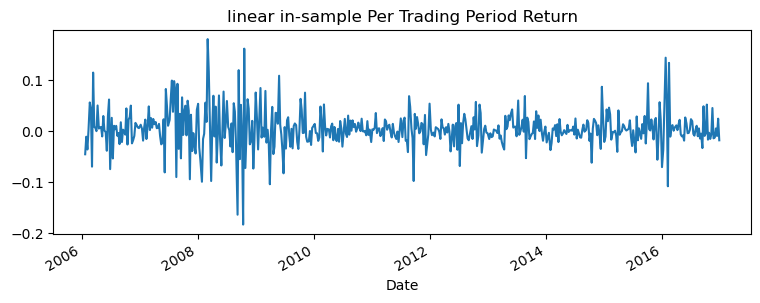

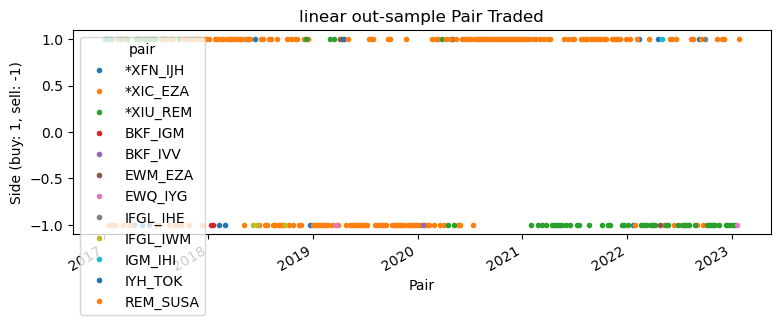

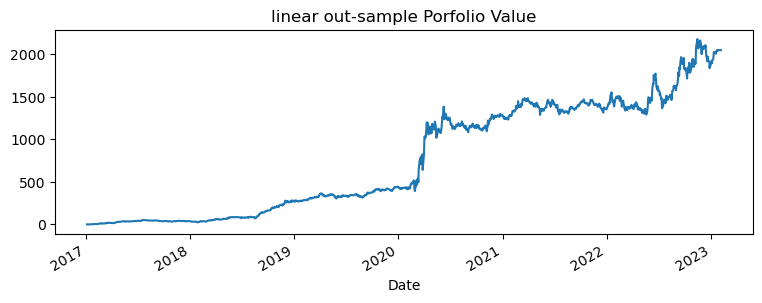

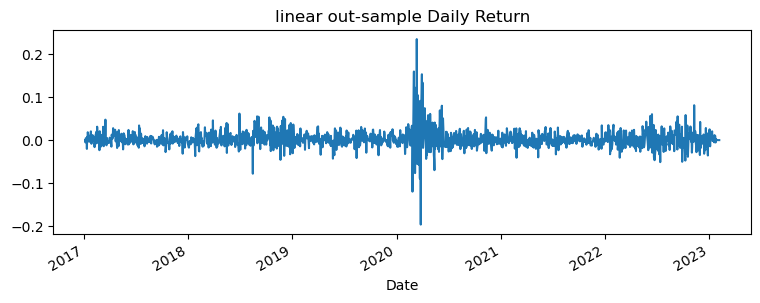

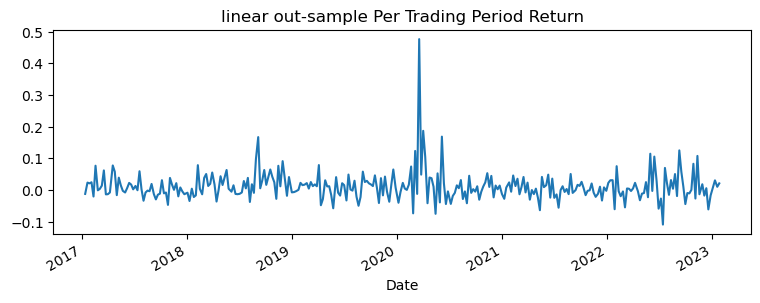

In [16]:
pipeline.run('linear', periodic=True, params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

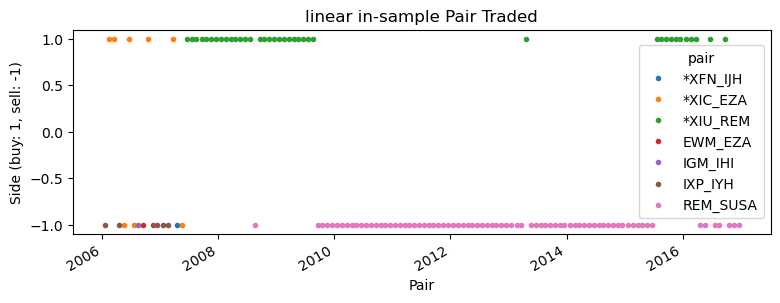

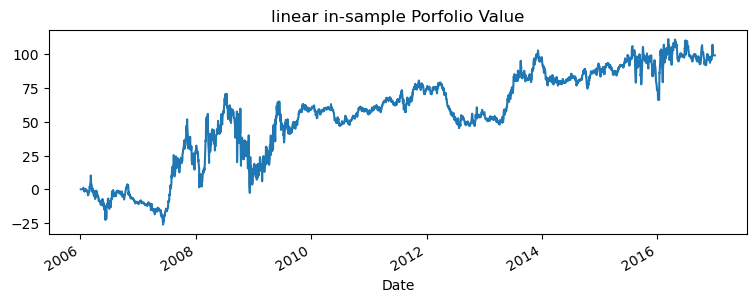

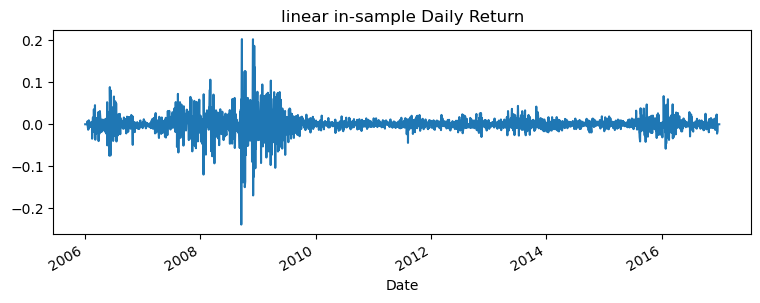

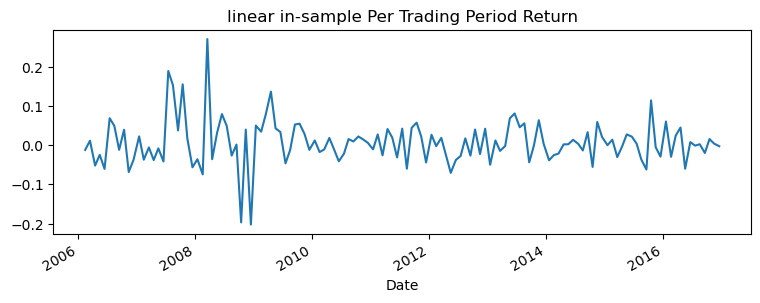

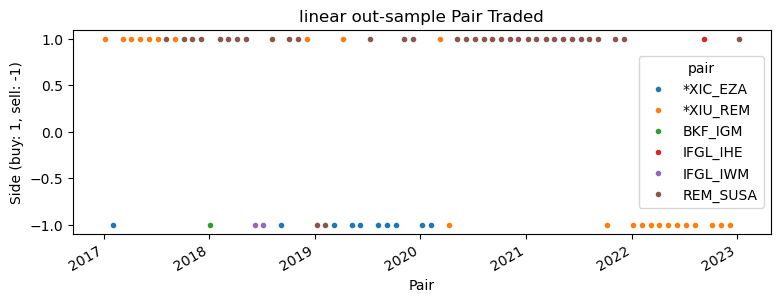

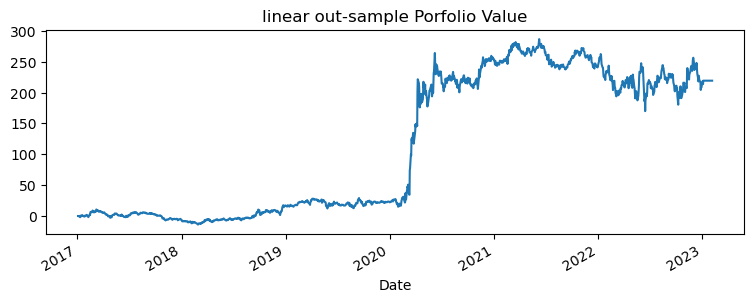

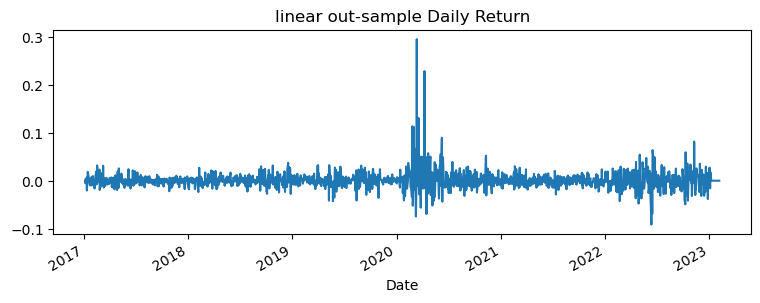

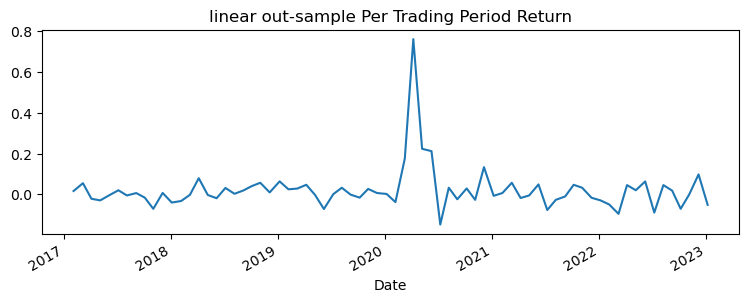

In [17]:
pipeline.run('linear', periodic=True, params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

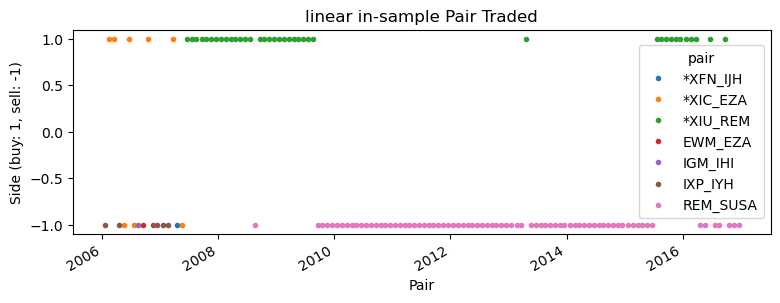

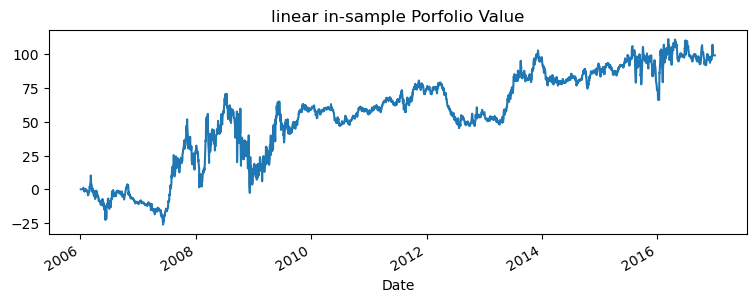

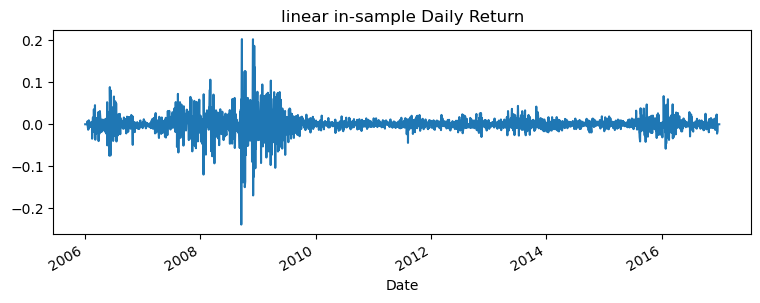

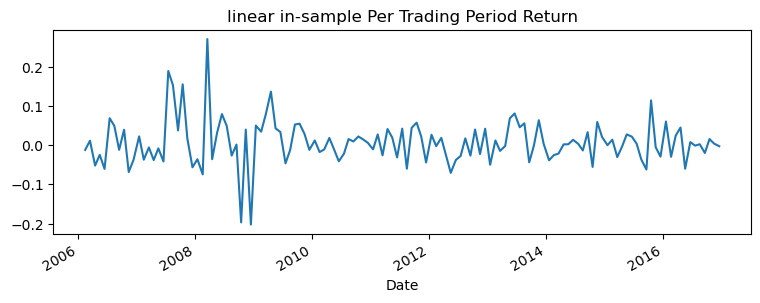

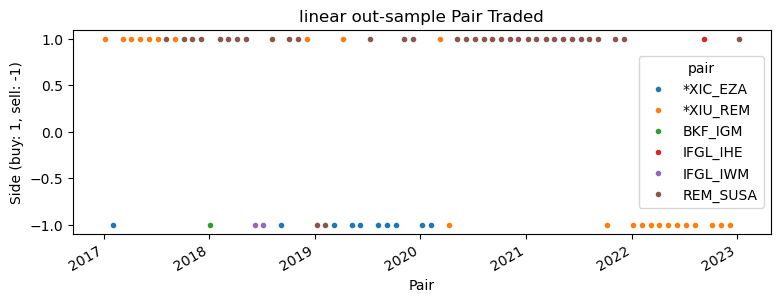

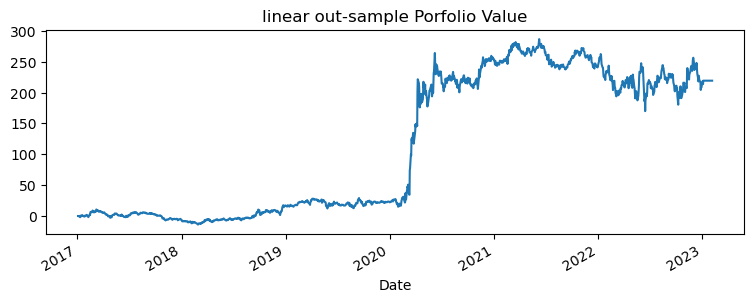

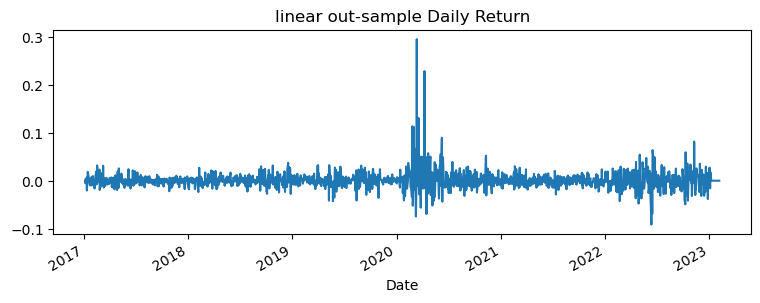

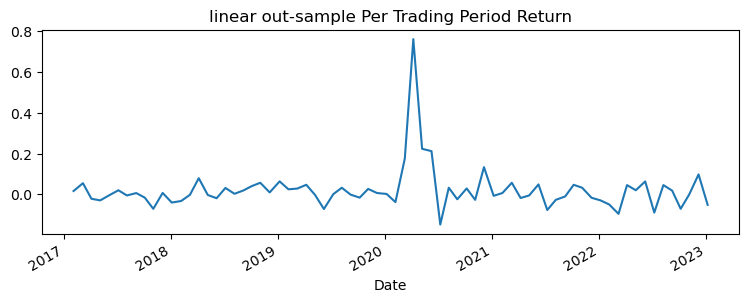

In [18]:
pipeline.run('linear', periodic=True, params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

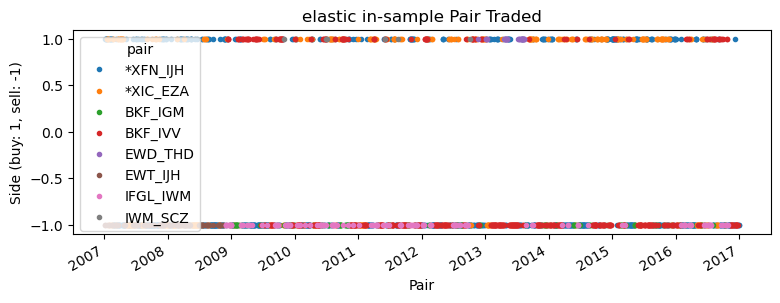

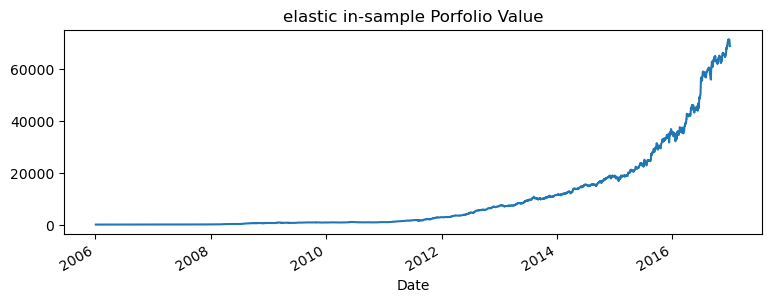

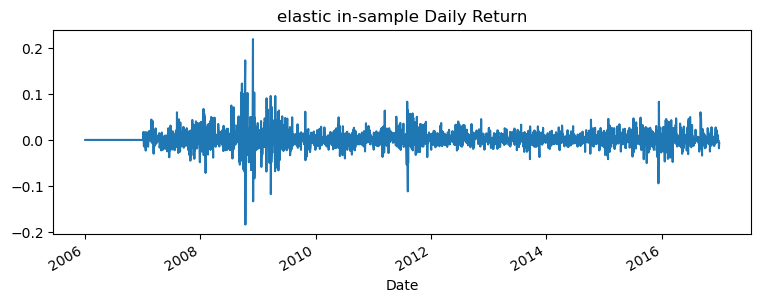

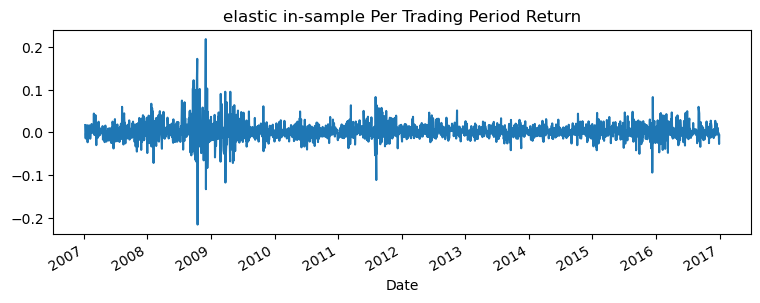

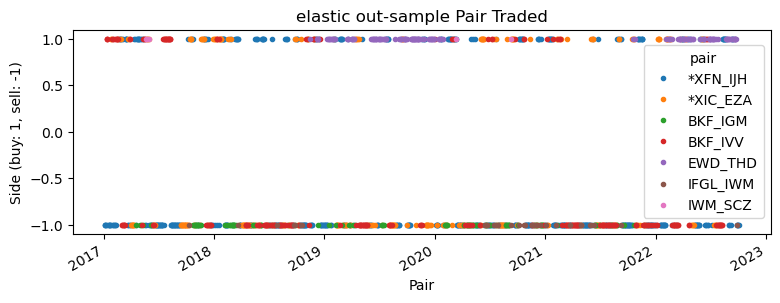

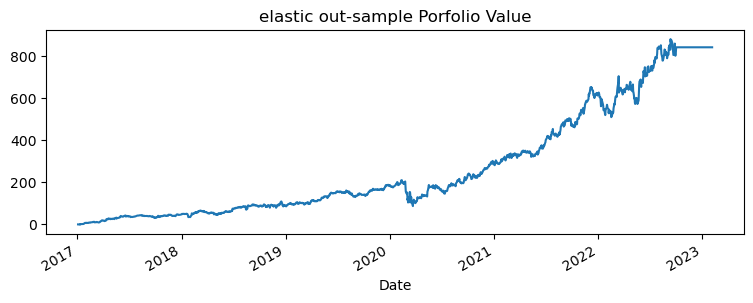

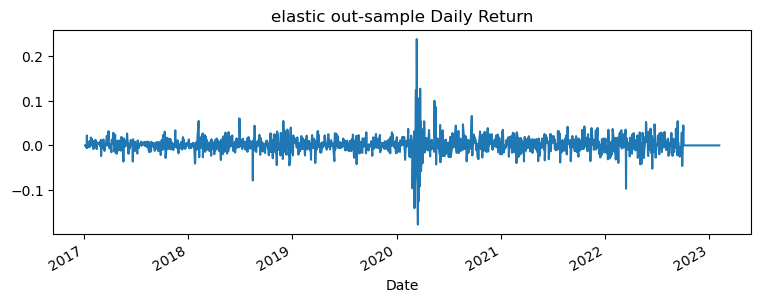

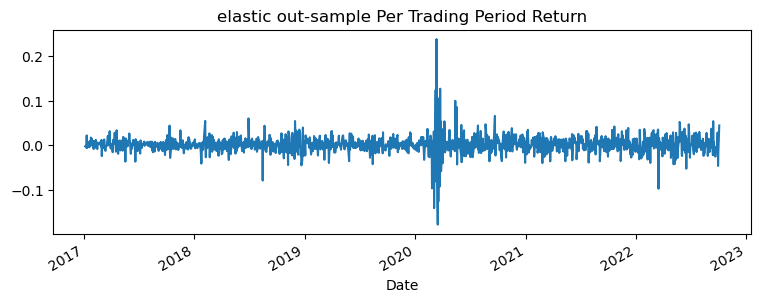

In [19]:
pipeline.run('elastic', params = {
                'pred_period': 'D',
                'cost' : 100,
                'holding_period': 1,
            })

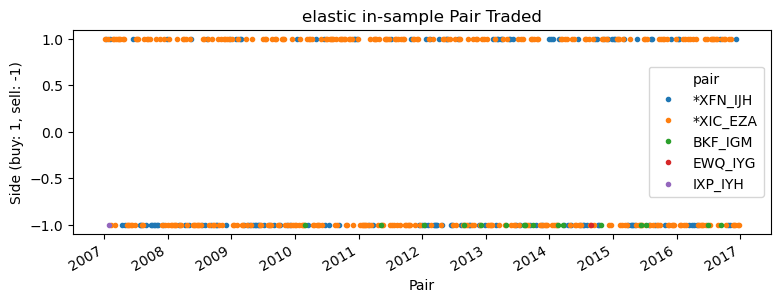

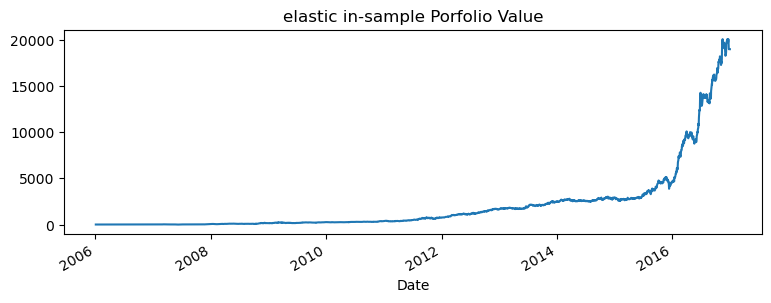

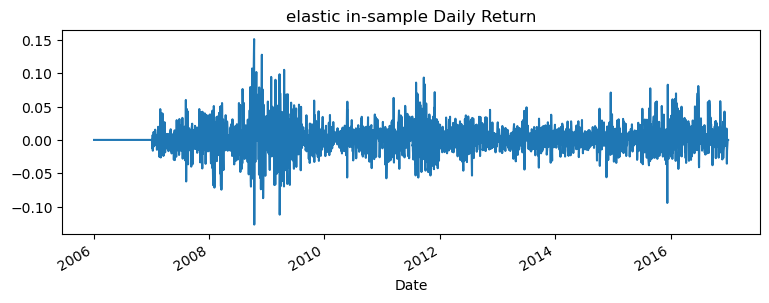

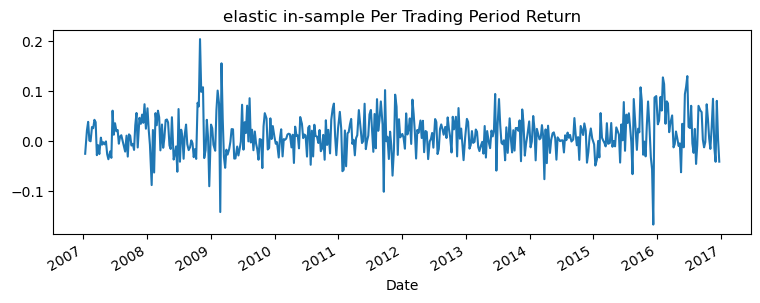

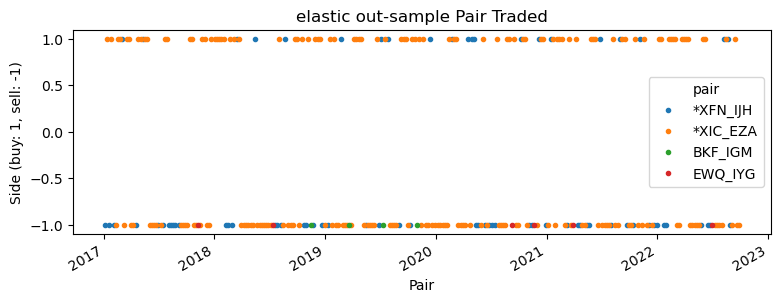

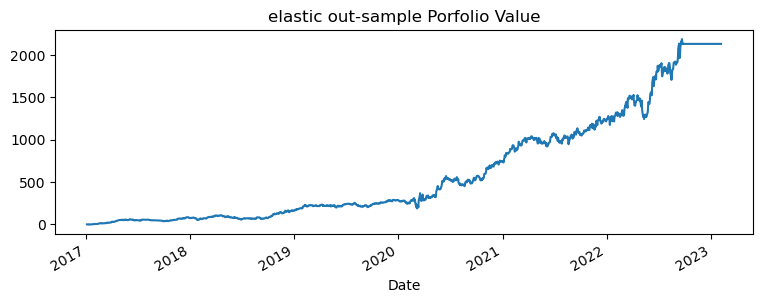

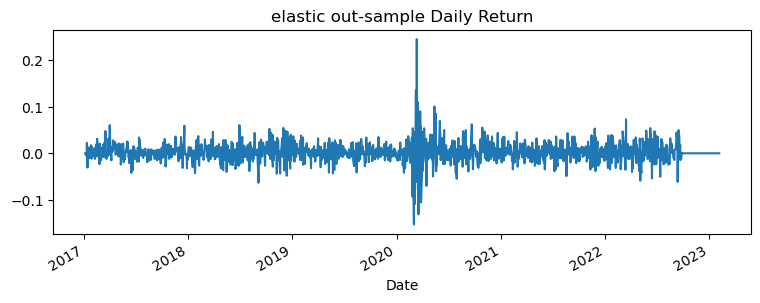

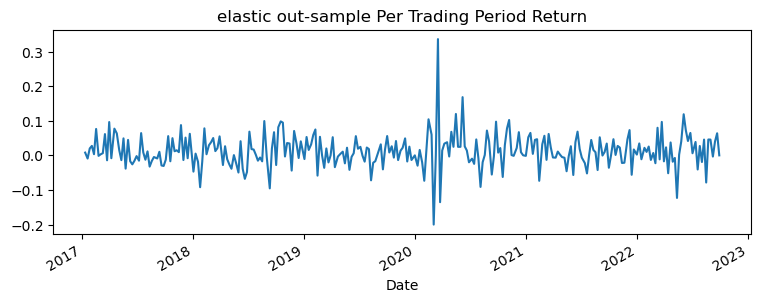

In [20]:
pipeline.run('elastic', params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

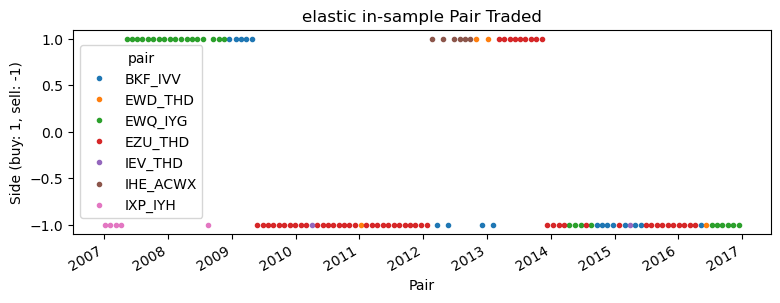

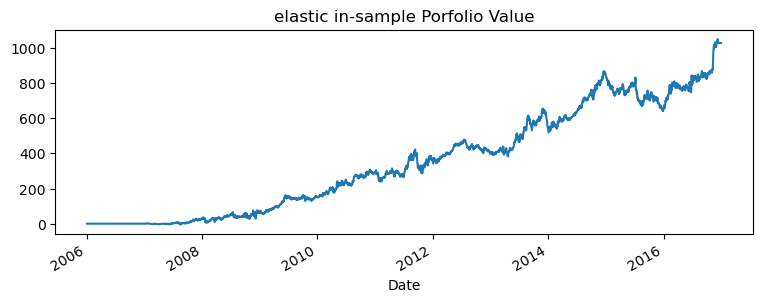

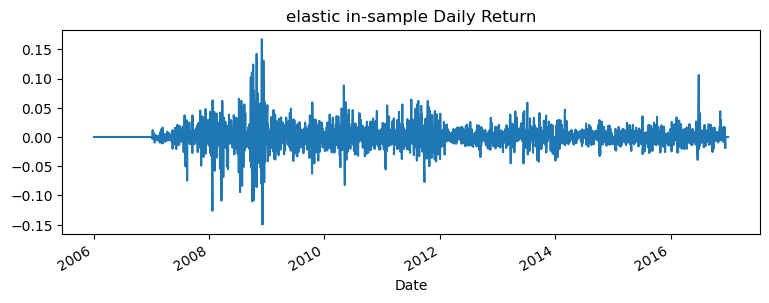

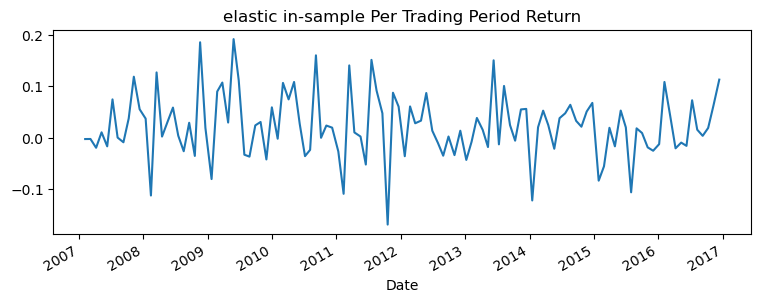

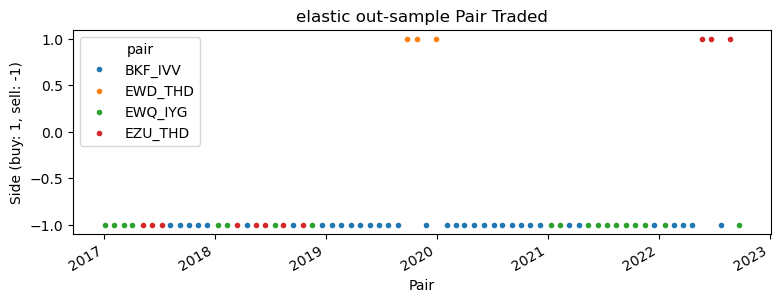

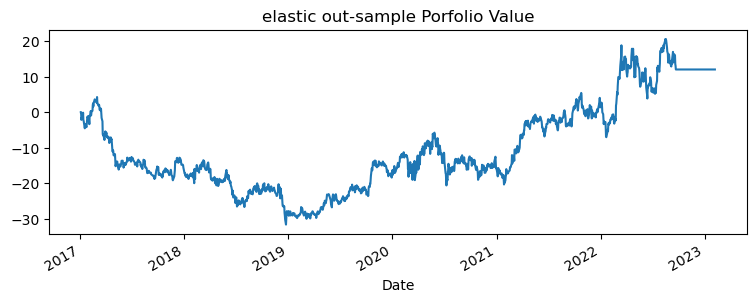

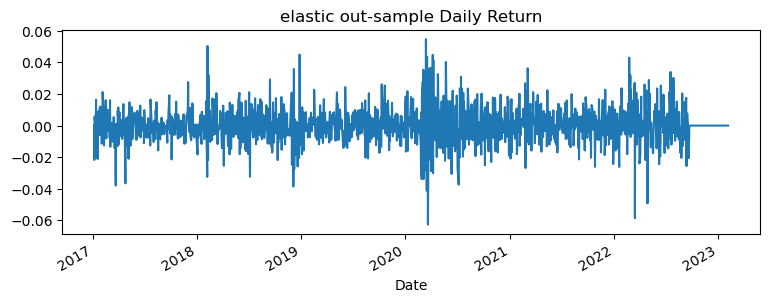

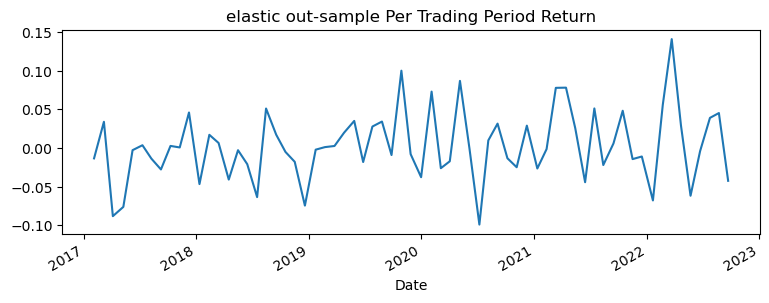

In [21]:
pipeline.run('elastic', params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

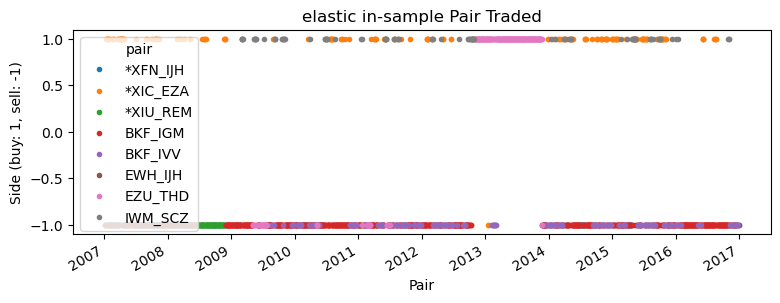

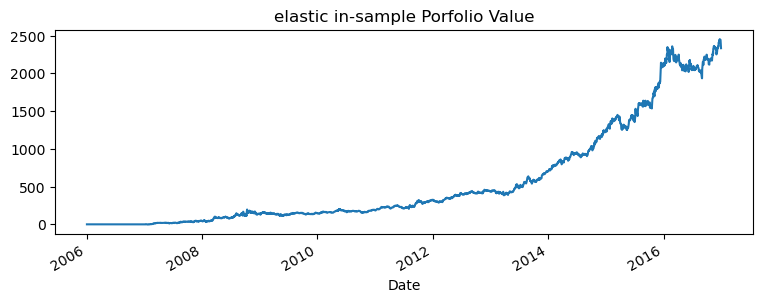

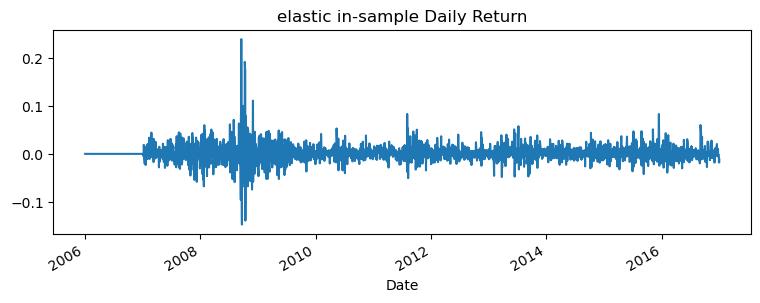

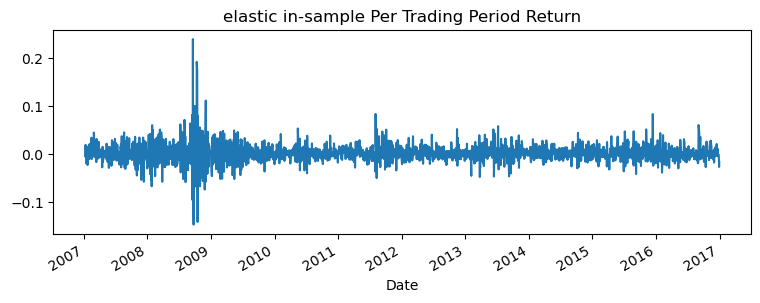

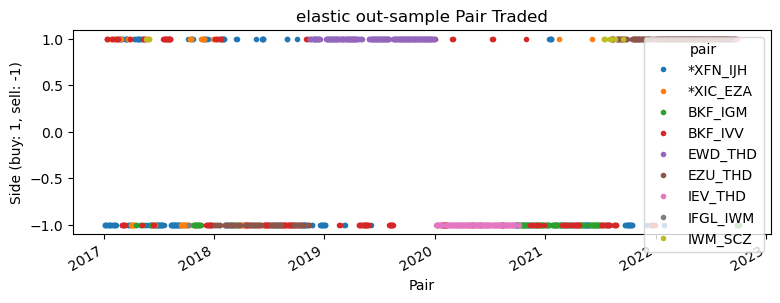

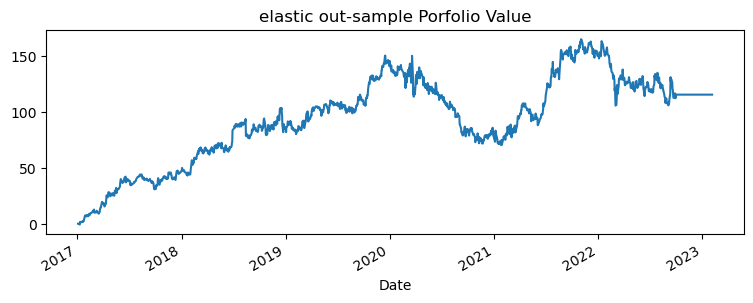

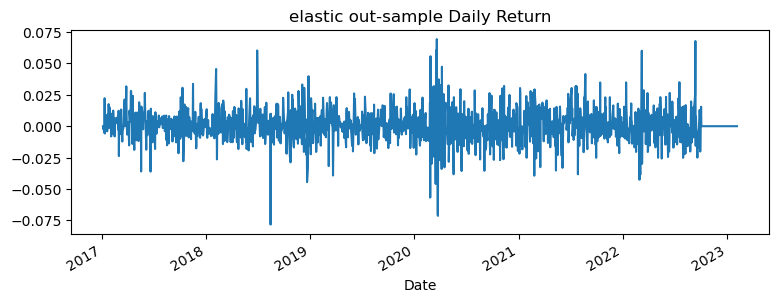

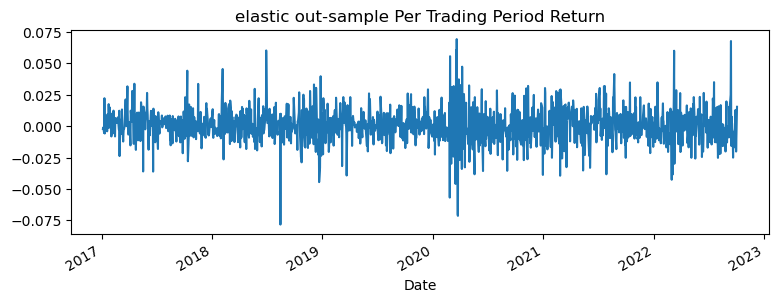

In [22]:
p_df = pipeline.run('elastic', periodic=True, params = {
                'pred_period': 'D',
                'cost' : 100.,
                'holding_period': 1,
            })

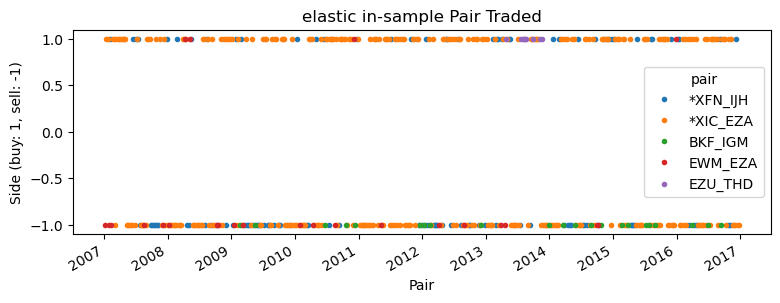

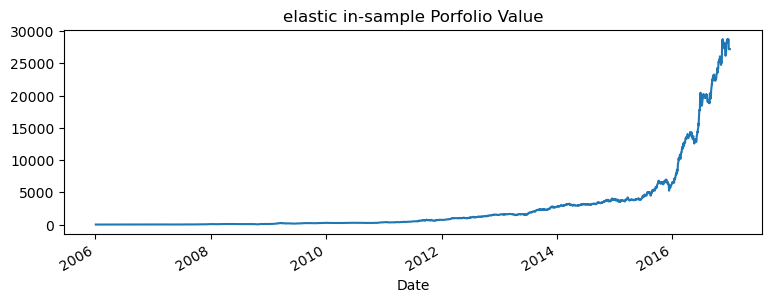

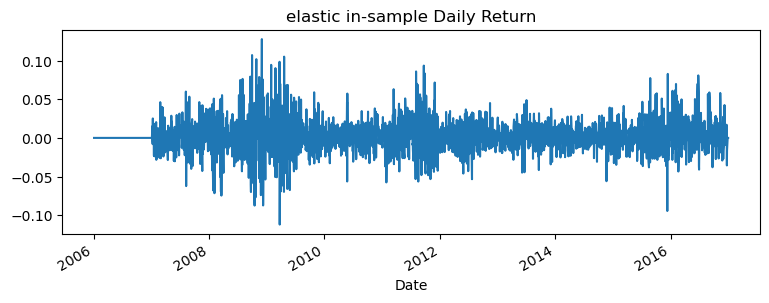

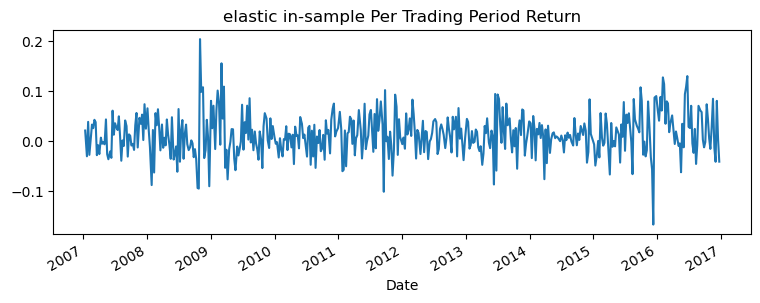

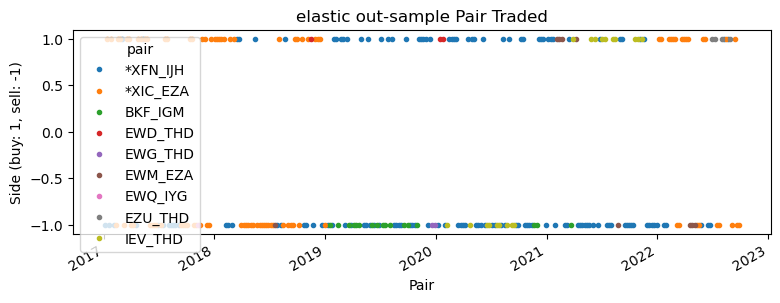

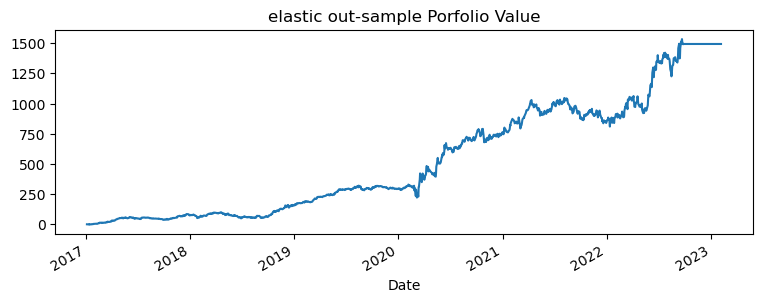

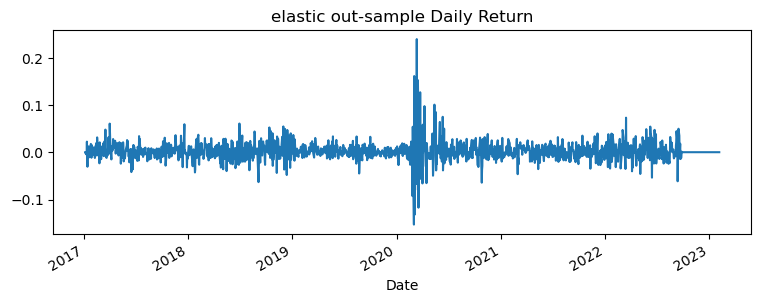

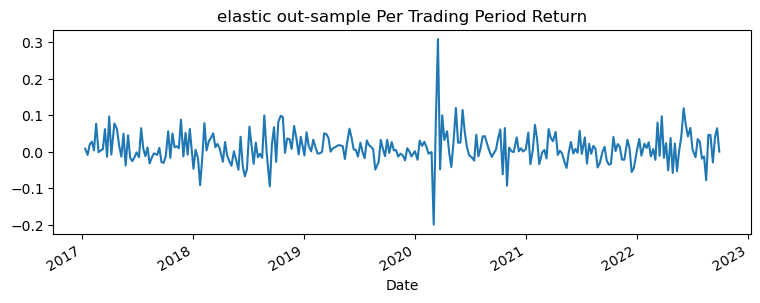

In [23]:
pipeline.run('elastic', periodic=True, params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

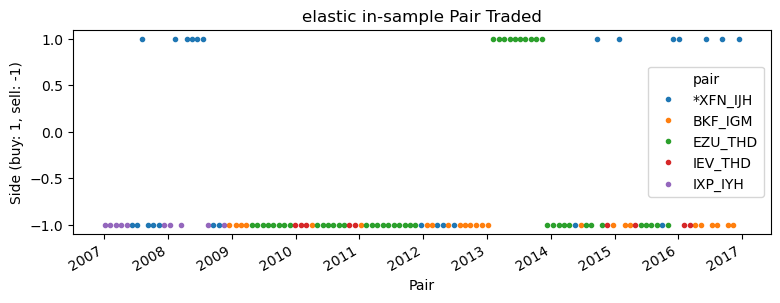

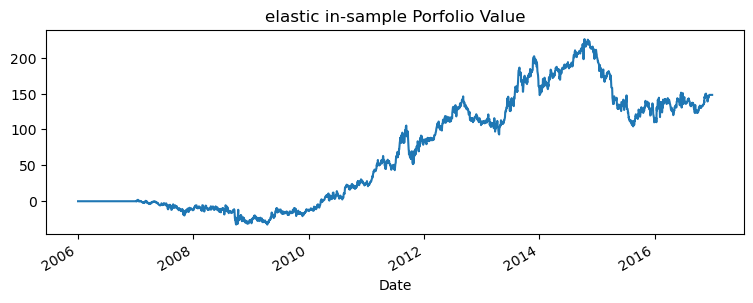

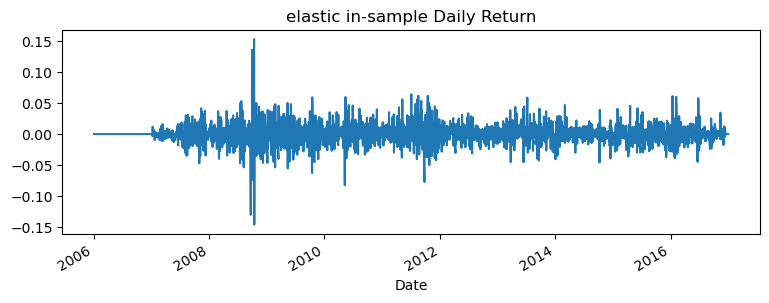

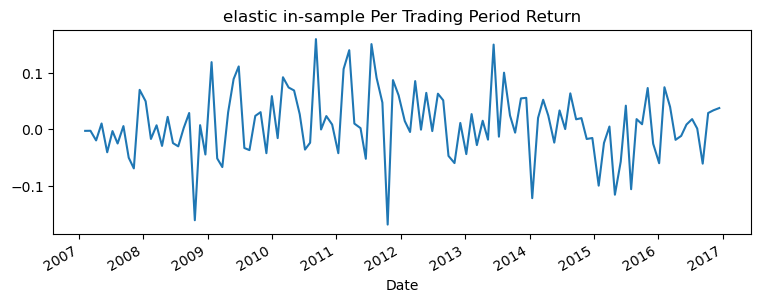

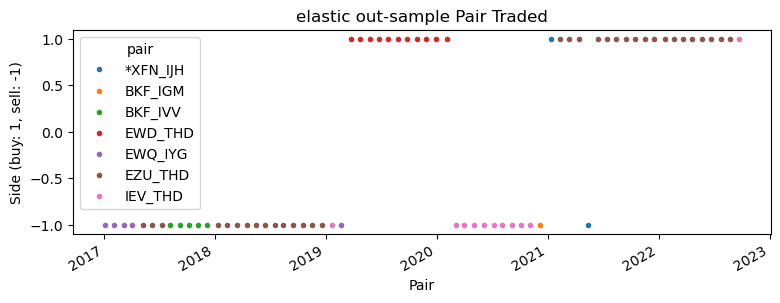

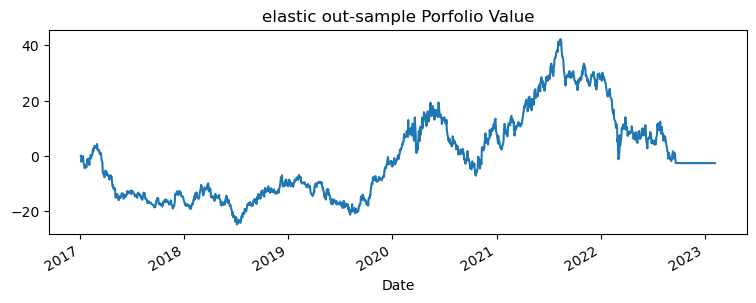

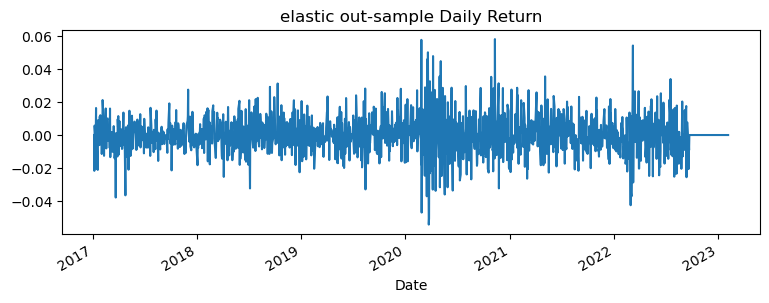

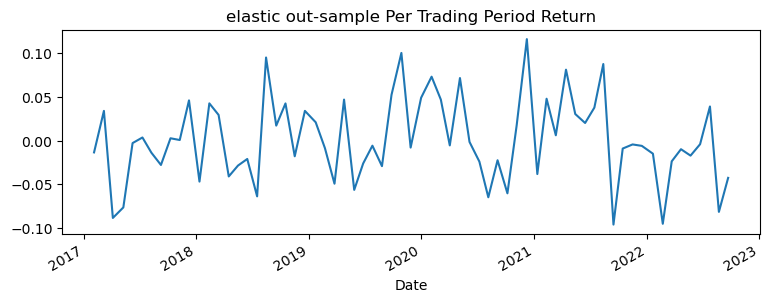

In [24]:
pipeline.run('elastic', periodic=True, params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

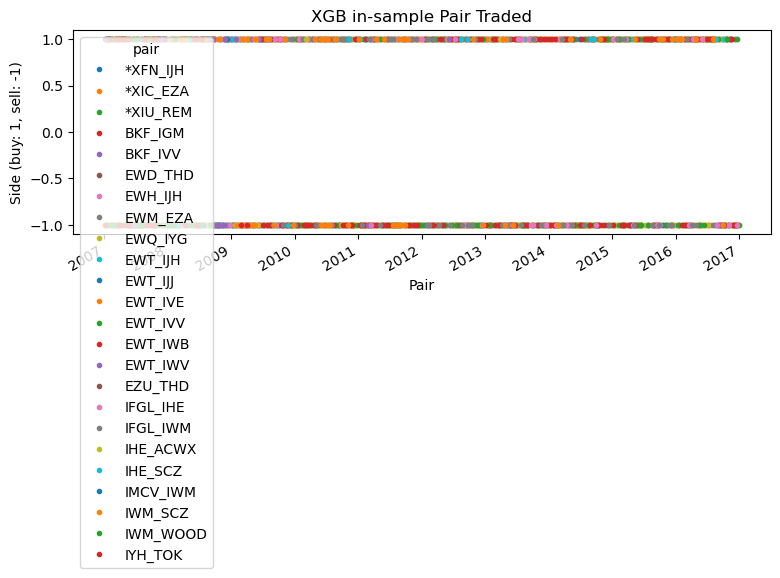

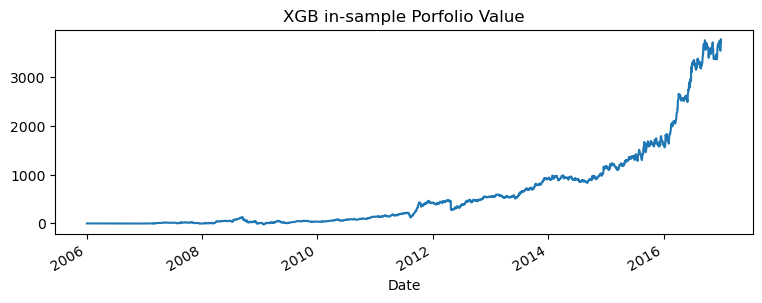

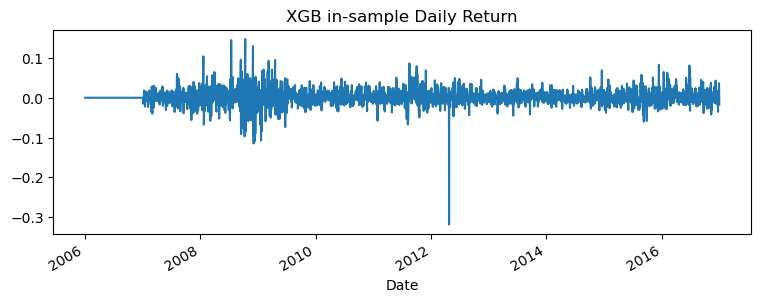

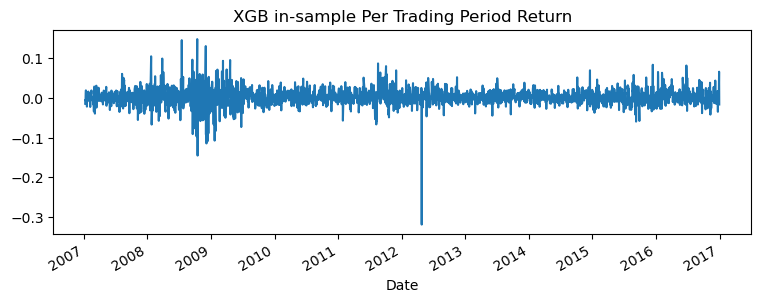

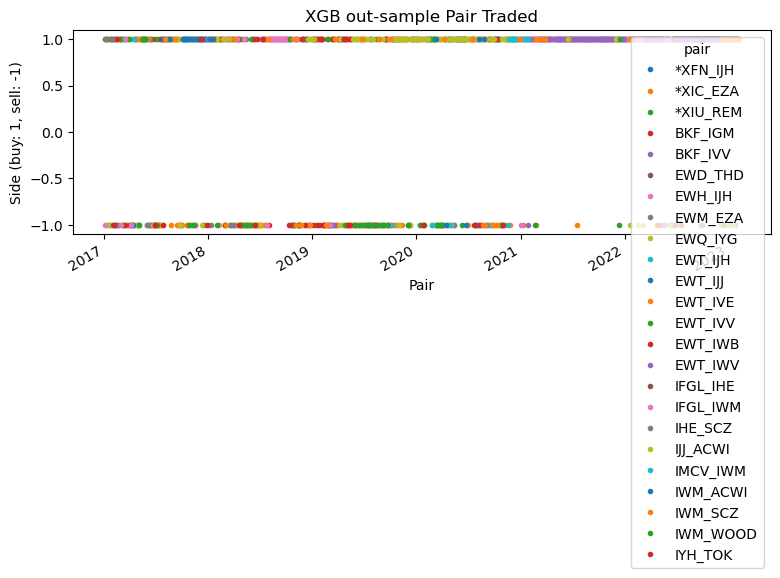

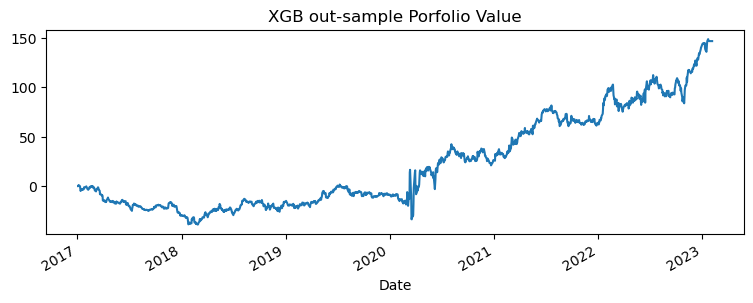

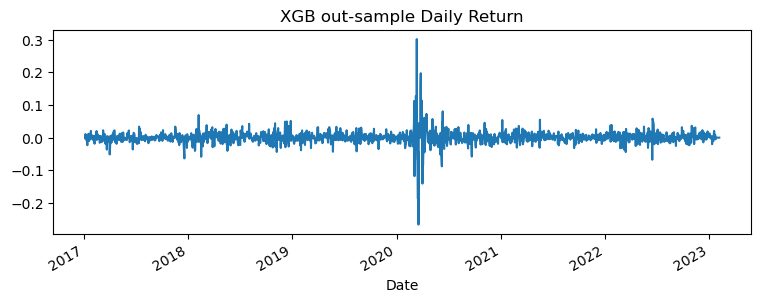

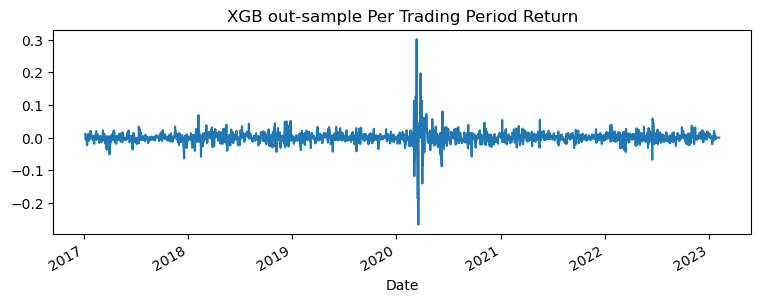

In [25]:
pipeline.run('XGB', params = {
                'pred_period': 'D',
                'cost' : 100,
                'holding_period': 1,
            })

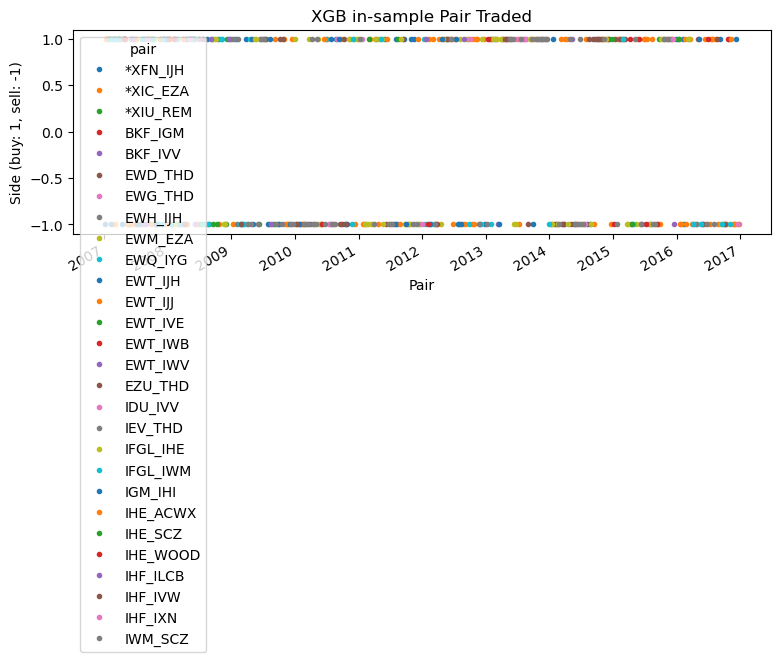

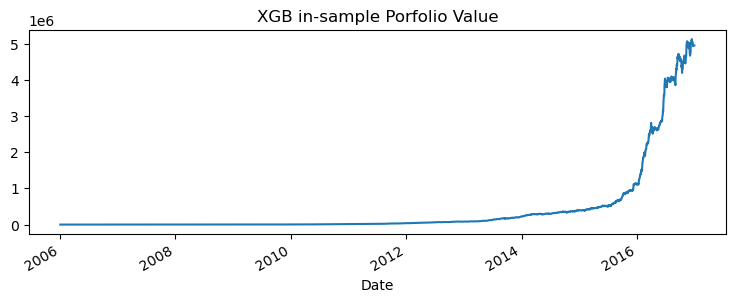

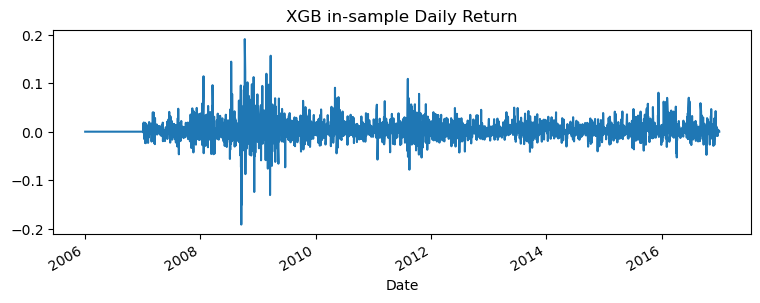

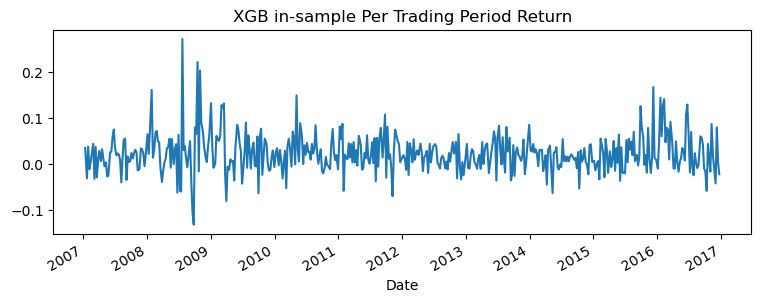

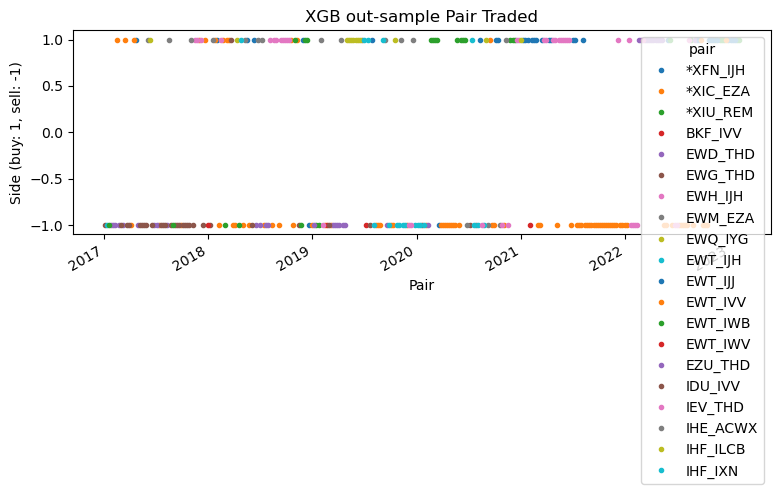

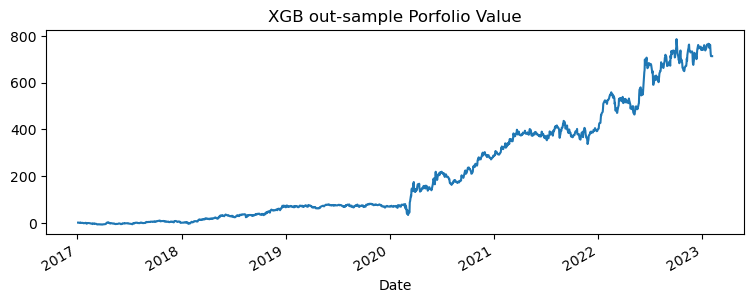

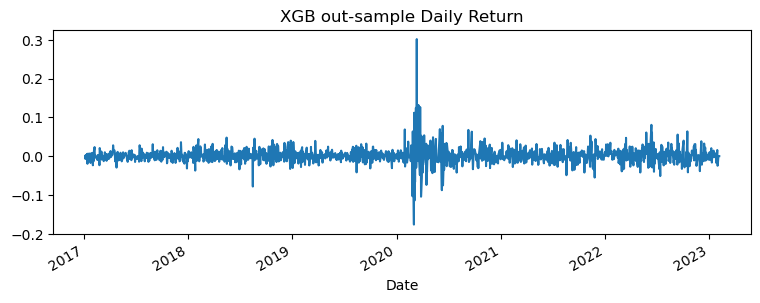

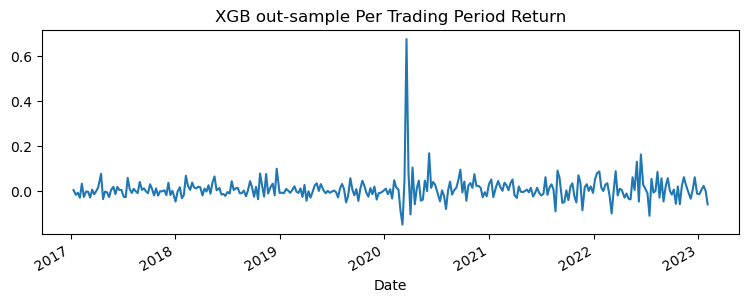

In [26]:
pipeline.run('XGB', params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

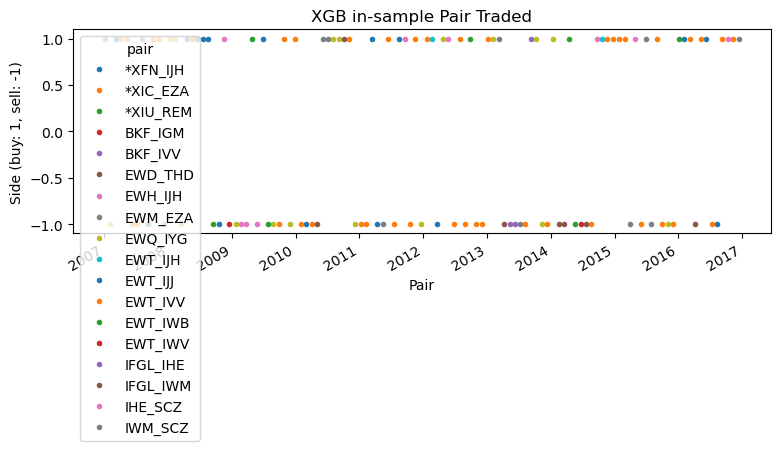

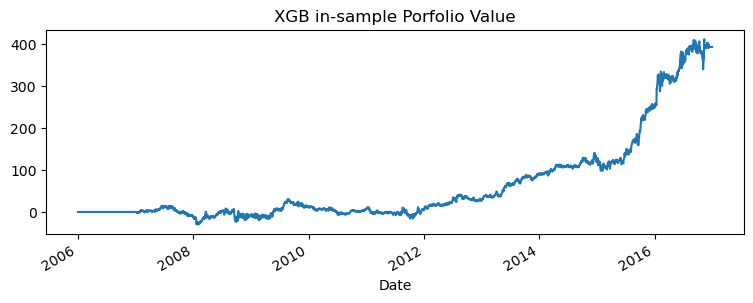

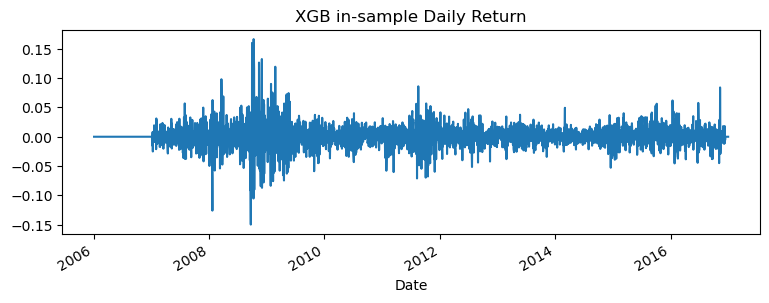

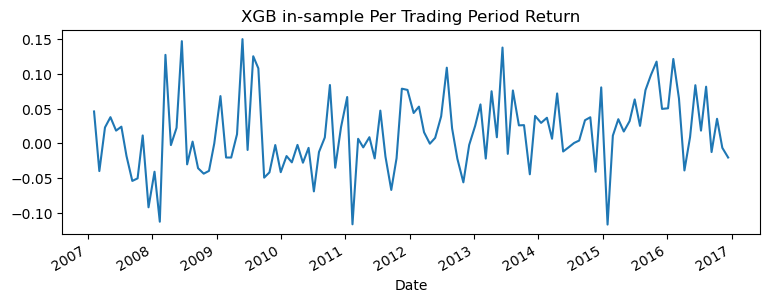

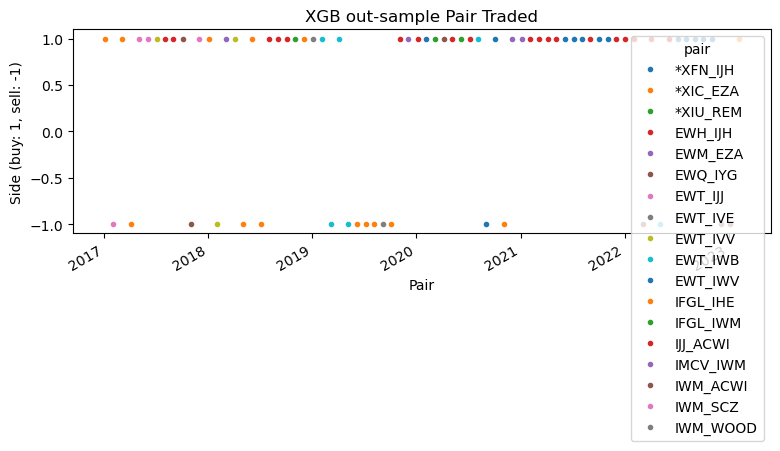

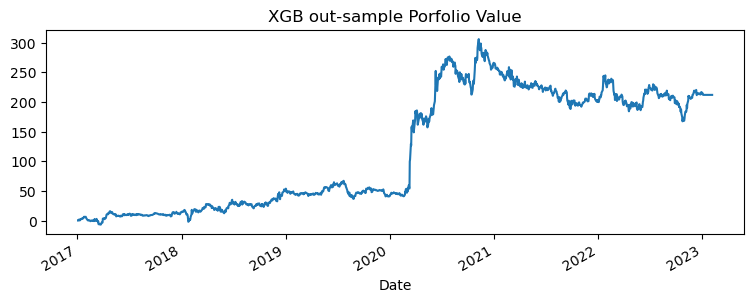

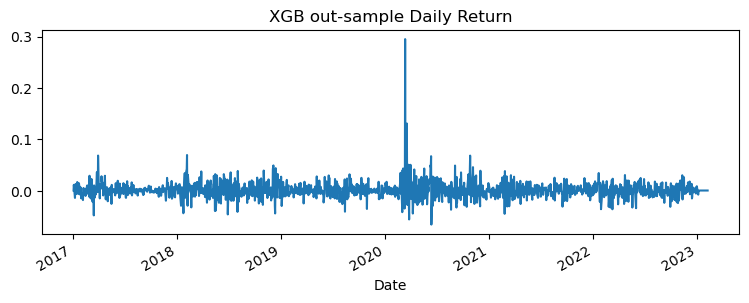

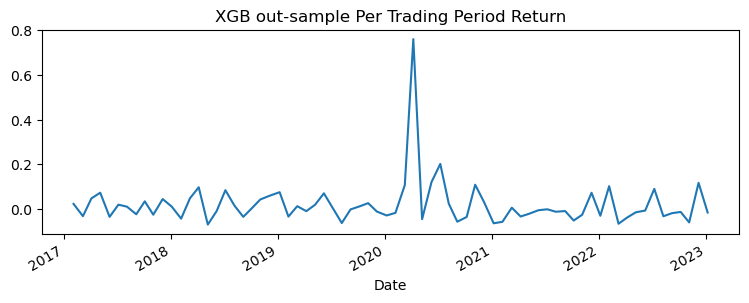

In [27]:
pipeline.run('XGB', params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 21,
            })

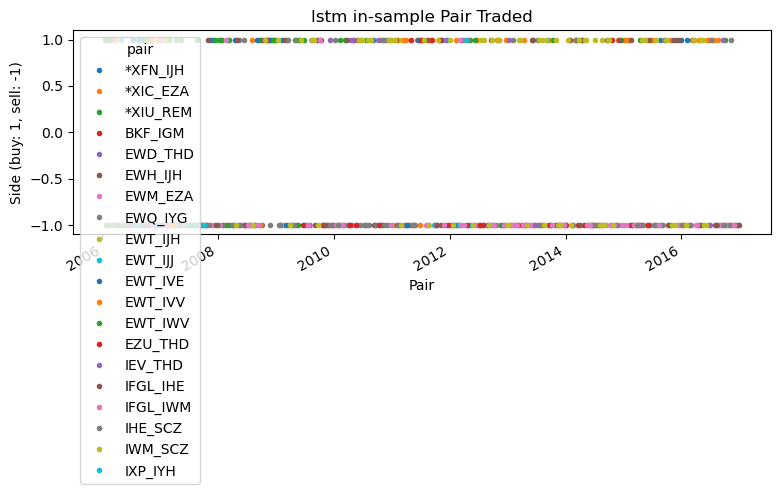

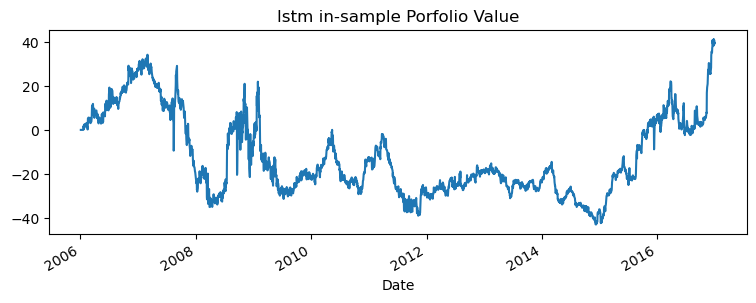

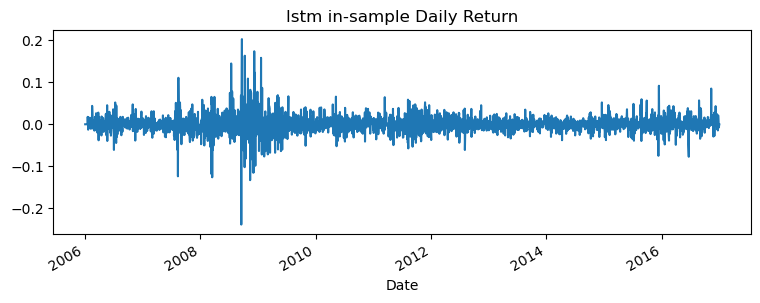

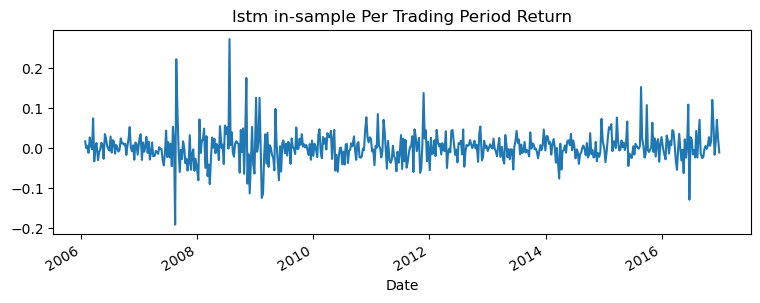

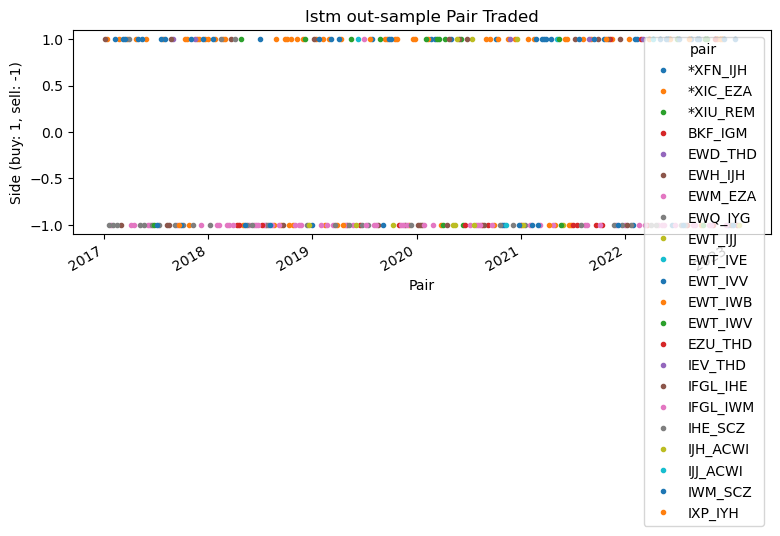

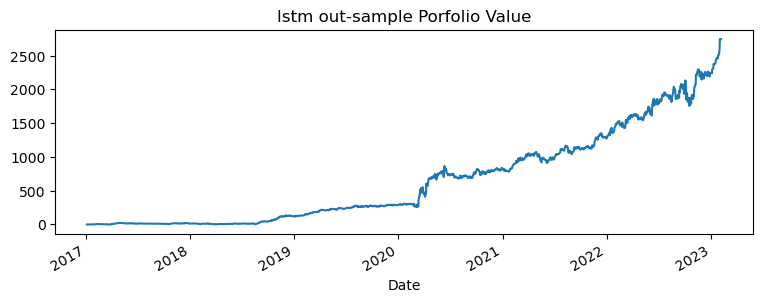

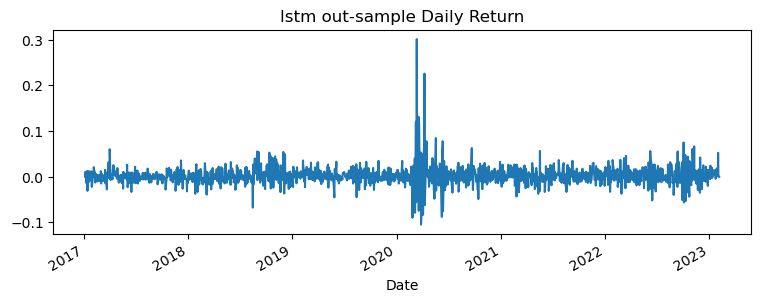

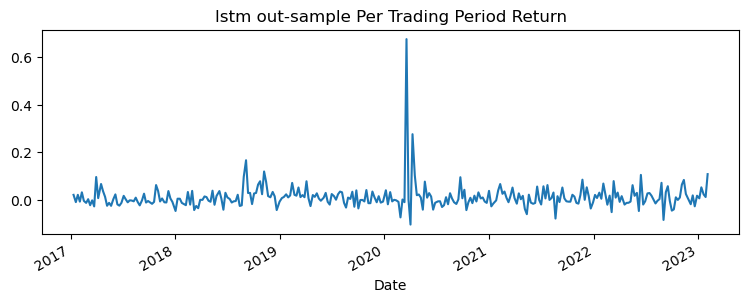

In [28]:
pipeline.run('lstm', params = {
                'pred_period': 'D',
                'cost' : 100,
                'holding_period': 5,
            })

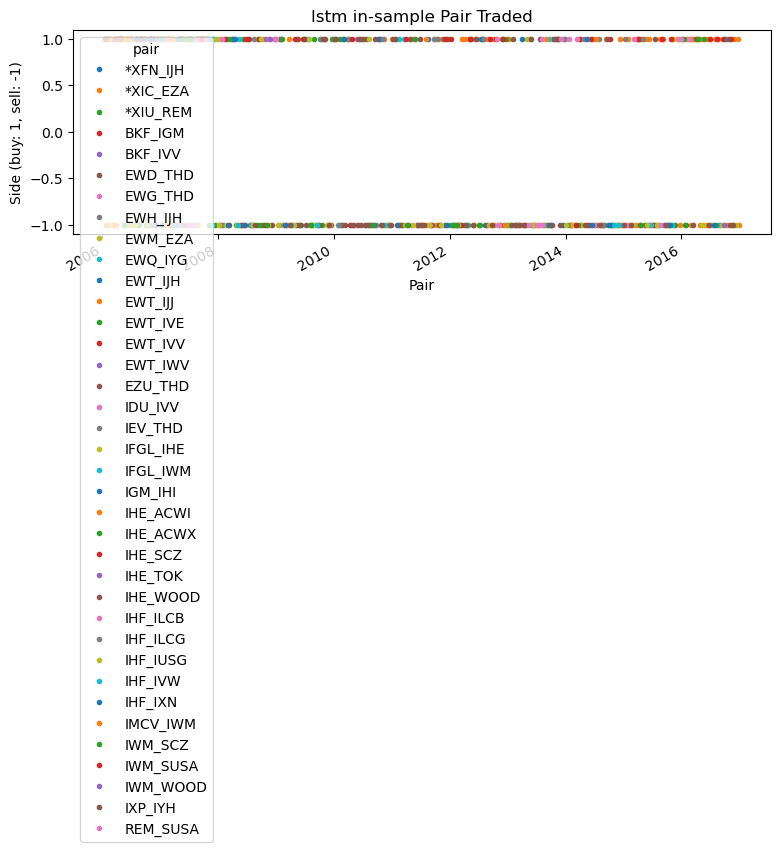

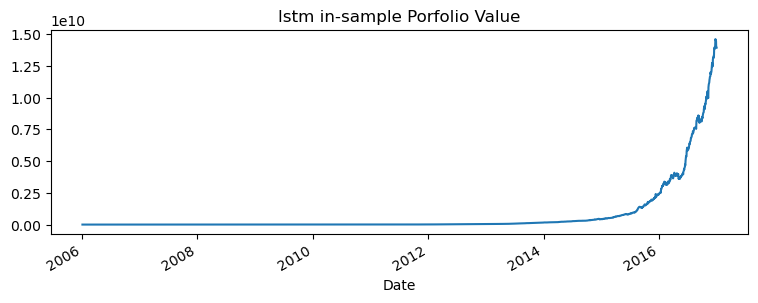

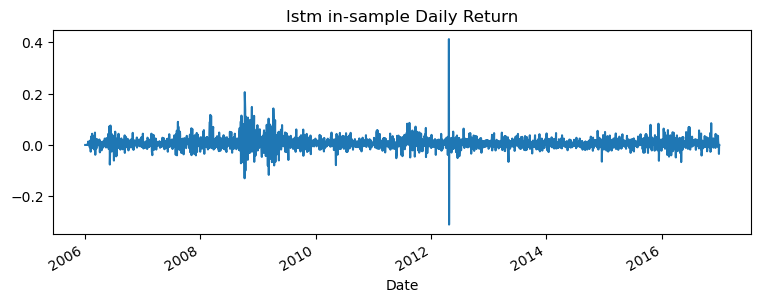

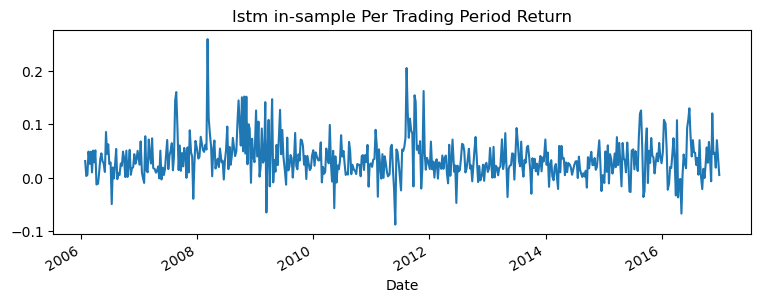

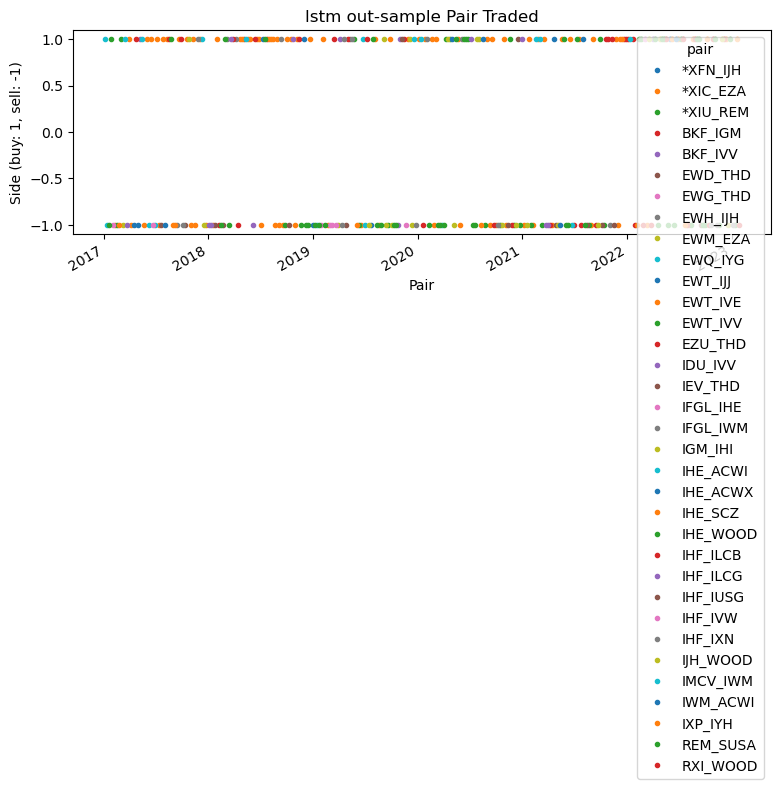

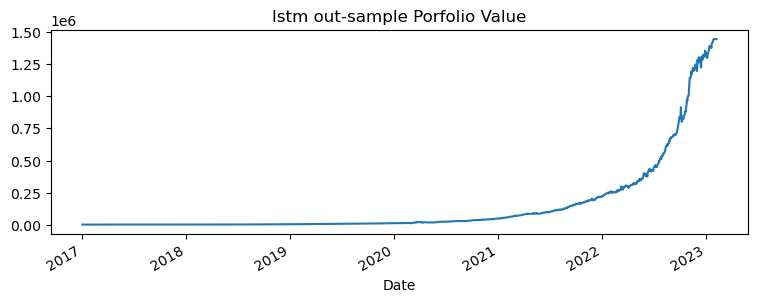

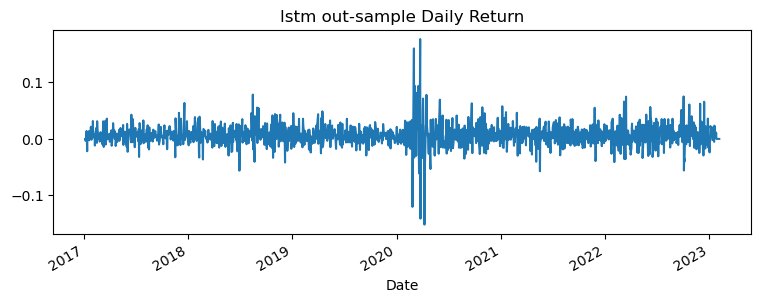

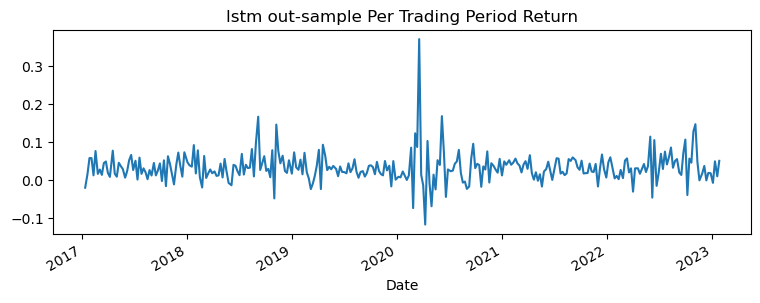

In [29]:
pipeline.run('lstm', params = {
                'pred_period': 'W',
                'cost' : 100,
                'holding_period': 5,
            })

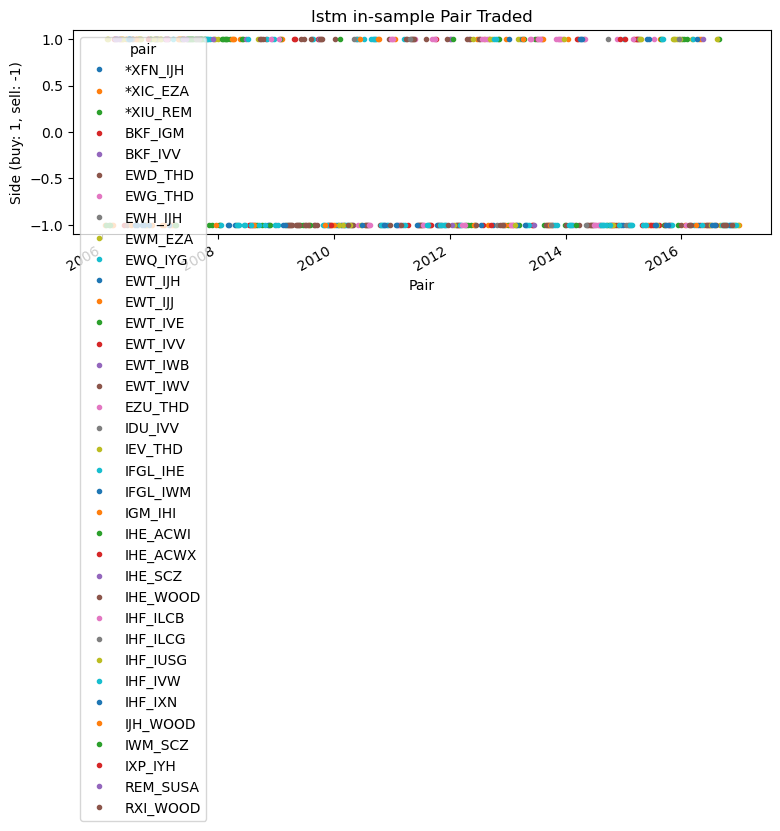

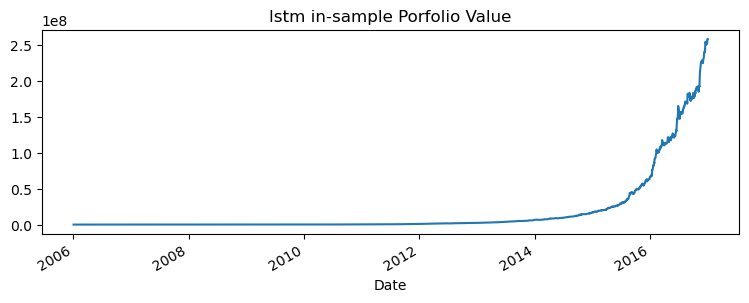

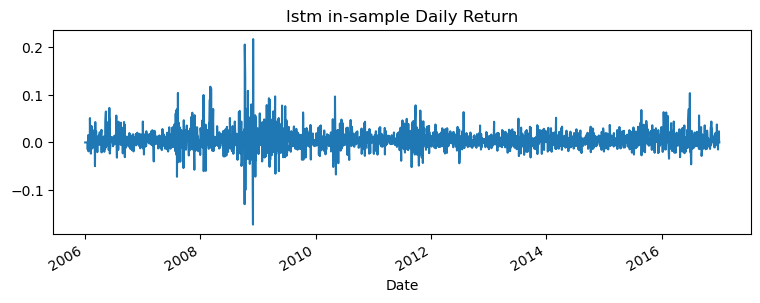

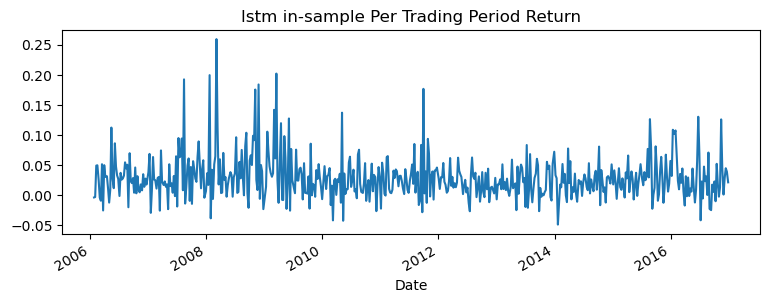

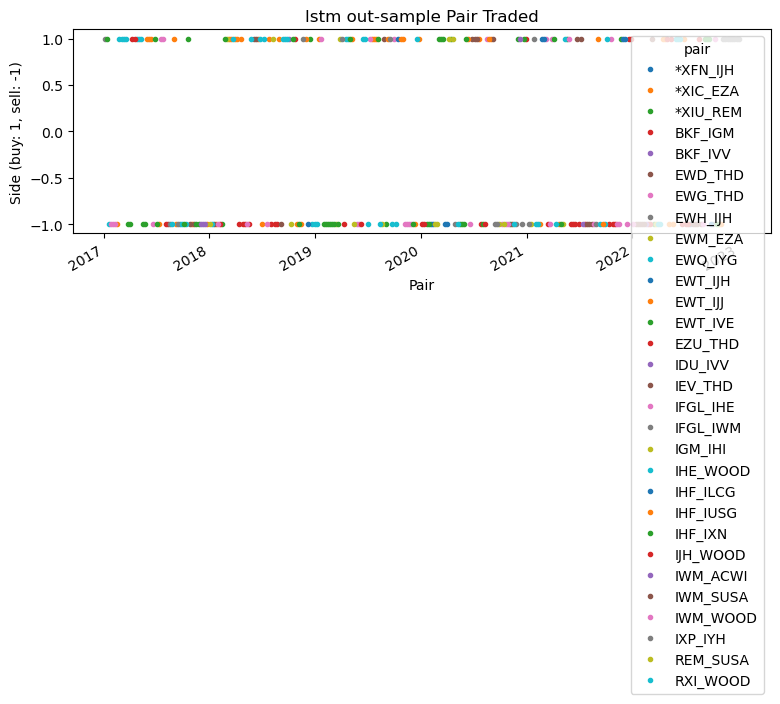

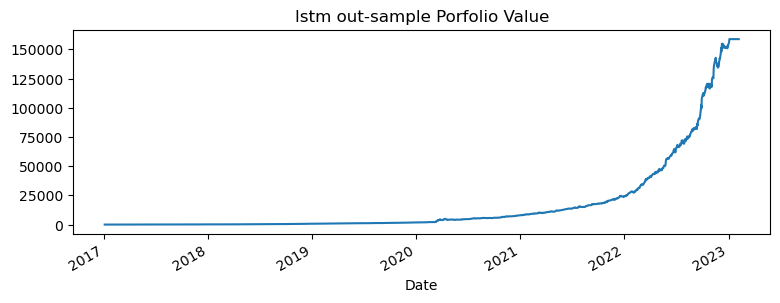

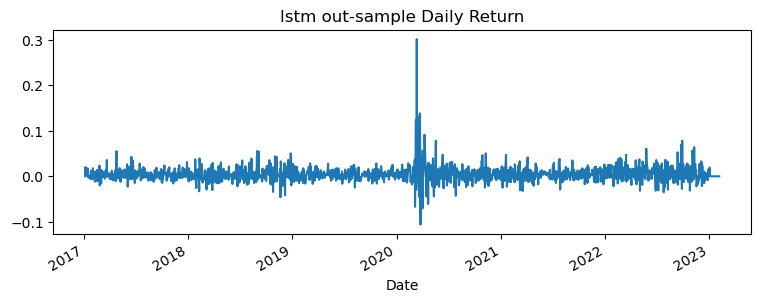

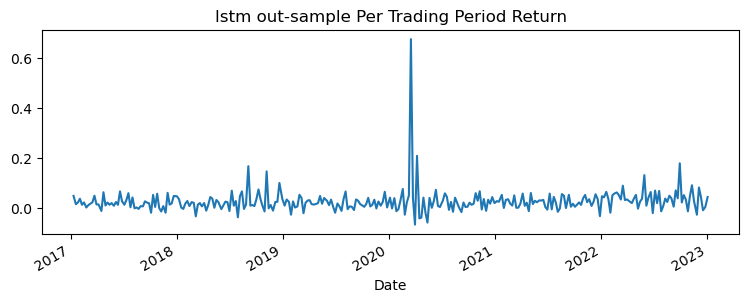

In [30]:
pipeline.run('lstm', params = {
                'pred_period': 'M',
                'cost' : 100,
                'holding_period': 5,
            })

In [31]:
# pipeline.run('percentile_current', params = {
#                 'pred_period': 'D',
#                 'holding_period': 1,
#                 'distribution_period': 10,
#                 'training_period':2769,
#                 'periodic': False,
#                 'cost': 100
#             }, currentMode=True)

In [32]:
# pipeline.run('percentile_current', params = {
#                 'pred_period': 'W',
#                 'holding_period': 5,
#                 'distribution_period': 21,
#                 'training_period':2769,
#                 'periodic': False,
#                 'cost': 100
#             }, currentMode=True)


In [33]:
# pipeline.run('percentile_current', params = {
#                 'pred_period': 'M',
#                 'holding_period': 21,
#                 'distribution_period': 63,
#                 'training_period':2769,
#                 'periodic': False,
#                 'cost': 100
#             }, currentMode=True)

In [34]:
# pipeline.run('percentile_current', params = {
#                 'pred_period': 'D',
#                 'holding_period': 1,
#                 'distribution_period': 10,
#                 'training_period':63,
#                 'periodic': True,
#                 'cost': 100
#             }, periodic=True, currentMode=True)

In [35]:
# pipeline.run('percentile_current', params = {
#                 'pred_period': 'W',
#                 'holding_period': 5,
#                 'distribution_period': 21,
#                 'training_period':63,
#                 'periodic': True,
#                 'cost': 100
#             }, periodic=True, currentMode=True)

In [36]:
# pipeline.run('percentile_current', params = {
#                 'pred_period': 'M',
#                 'holding_period': 21,
#                 'distribution_period': 63,
#                 'training_period':84,
#                 'periodic': True,
#                 'cost': 100
#             }, periodic=True, currentMode=True)

In [37]:
def ret_sum(reg_df, name):
    nav_df, result_df = performance_for_df(reg_df, rf=0.0)
    print('--------------------------------')
    print(name)
    print(result_df)
    NAV_df_plot(nav_df, nav_df.columns.tolist(), nav_df.columns.tolist(),
                labels=nav_df.columns.tolist(), fig_path=name+".jpg")

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by z

--------------------------------
D in sample daily return
                          linear  linear_periodic     elastic  \
Simple Return          27.513093       103.560935  690.076955   
Annualized Return       0.356501         0.526785    0.813086   
Annualized Volatility   0.259845         0.337428    0.303163   
Sharpe Ratio            1.371976         1.561180    2.682013   
Adjusted Sharpe Ratio   0.642966         0.651185   -7.369235   
Sortino Ratio           1.908433         2.105636    3.674265   
Maximum Drawdown        0.000000         0.000000    0.000000   
Calmar Ratio                 inf              inf         inf   

                       elastic_periodic        XGB      lstm  
Simple Return                 23.326739  37.118559  0.394759  
Annualized Return              0.337039   0.392821  0.030743  
Annualized Volatility          0.282161   0.328194  0.347090  
Sharpe Ratio                   1.194493   1.196918  0.088574  
Adjusted Sharpe Ratio         -0.002072  

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by z

--------------------------------
D in sample period return
                          linear  linear_periodic   elastic  elastic_periodic  \
Simple Return          27.513093         1.405823  4.812250          0.814163   
Annualized Return       3.603182         0.491902  1.230020          0.311831   
Annualized Volatility   0.546719         0.395980  0.366713          0.321507   
Sharpe Ratio            6.590558         1.242240  3.354175          0.969902   
Adjusted Sharpe Ratio -53.538379         0.447245 -9.026940          0.481953   
Sortino Ratio          11.232924         1.463760  5.217842          1.268921   
Maximum Drawdown        0.000000         0.000000  0.000000          0.000000   
Calmar Ratio                 inf              inf       inf               inf   

                             XGB  lstm  
Simple Return           2.519432   NaN  
Annualized Return       0.774294   NaN  
Annualized Volatility   0.414343   NaN  
Sharpe Ratio            1.868728   NaN  
Adjust

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by z

--------------------------------
D out sample daily return
                         linear  linear_periodic   elastic  elastic_periodic  \
Simple Return          3.988261         9.445110  8.397429          1.157629   
Annualized Return      0.302137         0.470224  0.444915          0.134657   
Annualized Volatility  0.287628         0.329643  0.306826          0.209677   
Sharpe Ratio           1.050442         1.426463  1.450058          0.642212   
Adjusted Sharpe Ratio  0.199224        -0.333064 -1.318893          0.628328   
Sortino Ratio          1.598754         1.862889  1.830747          0.908636   
Maximum Drawdown       0.000000         0.000000  0.000000          0.000000   
Calmar Ratio                inf              inf       inf               inf   

                            XGB       lstm  
Simple Return          1.465512  27.461335  
Annualized Return      0.159795   0.733404  
Annualized Volatility  0.337501   0.334058  
Sharpe Ratio           0.473465   2.1954

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown


--------------------------------
D out sample period return
                           linear  linear_periodic   elastic  \
Simple Return            3.988261         0.184565       NaN   
Annualized Return        2.740326         0.149160       NaN   
Annualized Volatility    0.663653         0.324178  0.317053   
Sharpe Ratio             4.129155         0.460117       NaN   
Adjusted Sharpe Ratio -128.711754         0.385248       NaN   
Sortino Ratio            8.838598         0.518439       NaN   
Maximum Drawdown         0.000000         0.000000  0.000000   
Calmar Ratio                  inf              inf       NaN   

                       elastic_periodic       XGB          lstm  
Simple Return                       NaN -0.344486  2.746133e+01  
Annualized Return                   NaN -0.292963  1.462144e+01  
Annualized Volatility          0.200134  0.401488  8.385521e-01  
Sharpe Ratio                        NaN -0.729694  1.743653e+01  
Adjusted Sharpe Ratio            

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by z

--------------------------------
W in sample daily return
                          linear  linear_periodic     elastic  \
Simple Return          26.747261         6.269420  189.580012   
Annualized Return       0.353144         0.197852    0.612517   
Annualized Volatility   0.244920         0.332630    0.335749   
Sharpe Ratio            1.441874         0.594809    1.824332   
Adjusted Sharpe Ratio   0.551002         0.491701    1.652030   
Sortino Ratio           1.976559         0.750163    2.691309   
Maximum Drawdown        0.000000         0.000000    0.000000   
Calmar Ratio                 inf              inf         inf   

                       elastic_periodic           XGB          lstm  
Simple Return                272.190531  4.946618e+04  1.392785e+08  
Annualized Return              0.666237  1.674351e+00  4.510046e+00  
Annualized Volatility          0.330565  3.378474e-01  3.762405e-01  
Sharpe Ratio                   2.015453  4.955940e+00  1.198714e+01  
Adjust

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by z

--------------------------------
W in sample period return
                          linear  linear_periodic   elastic  elastic_periodic  \
Simple Return          26.747261         6.269420  1.804245          1.837371   
Annualized Return       3.546424         1.469347  0.599809          0.608393   
Annualized Volatility   0.498422         0.575861  0.663678          0.674332   
Sharpe Ratio            7.115309         2.551564  0.903764          0.902216   
Adjusted Sharpe Ratio   7.178756         1.525852  0.998032          0.997024   
Sortino Ratio          12.286036         3.595626  1.504571          1.515958   
Maximum Drawdown        0.000000         0.000000  0.000000          0.000000   
Calmar Ratio                 inf              inf       inf               inf   

                             XGB  lstm  
Simple Return          10.590407   NaN  
Annualized Return       2.054258   NaN  
Annualized Volatility   0.647560   NaN  
Sharpe Ratio            3.172307   NaN  
Adjust

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by z

--------------------------------
W out sample daily return
                         linear  linear_periodic    elastic  elastic_periodic  \
Simple Return         -0.143811        20.438933  21.266006         14.945564   
Annualized Return     -0.025184         0.654570   0.664891          0.576033   
Annualized Volatility  0.264830         0.335601   0.341894          0.327001   
Sharpe Ratio          -0.095094         1.950444   1.944728          1.761566   
Adjusted Sharpe Ratio -0.094137        -3.071933  -1.602734         -1.860137   
Sortino Ratio         -0.114173         2.976430   2.730474          2.547402   
Maximum Drawdown       0.000000         0.000000   0.000000          0.000000   
Calmar Ratio               -inf              inf        inf               inf   

                            XGB          lstm  
Simple Return          7.128348  1.447671e+04  
Annualized Return      0.410886  3.825083e+00  
Annualized Volatility  0.331276  3.120219e-01  
Sharpe Ratio       

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown


--------------------------------
W out sample period return
                         linear  linear_periodic  elastic  elastic_periodic  \
Simple Return         -0.143811        20.438933      NaN               NaN   
Annualized Return     -0.120027        11.482022      NaN               NaN   
Annualized Volatility  0.531139         0.737876  0.70972          0.599262   
Sharpe Ratio          -0.225981        15.560901      NaN               NaN   
Adjusted Sharpe Ratio -0.240447     -4621.326047      NaN               NaN   
Sortino Ratio         -0.224760        38.498446      NaN               NaN   
Maximum Drawdown       0.000000         0.000000  0.00000          0.000000   
Calmar Ratio               -inf              inf      NaN               NaN   

                              XGB          lstm  
Simple Return            7.635696  1.447671e+04  
Annualized Return        4.902941  2.668676e+03  
Annualized Volatility    0.859974  6.244975e-01  
Sharpe Ratio             5.7

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by z

--------------------------------
M in sample daily return
                         linear  linear_periodic    elastic  elastic_periodic  \
Simple Return          1.257986         0.993348  10.293108          1.482147   
Annualized Return      0.076940         0.064791   0.246849          0.086256   
Annualized Volatility  0.209071         0.335798   0.298725          0.262681   
Sharpe Ratio           0.368007         0.192946   0.826345          0.328369   
Adjusted Sharpe Ratio  0.340283         0.187072   0.656808          0.321448   
Sortino Ratio          0.481215         0.233160   1.059190          0.446137   
Maximum Drawdown       0.000000         0.000000   0.000000          0.000000   
Calmar Ratio                inf              inf        inf               inf   

                            XGB          lstm  
Simple Return          3.939153  2.588342e+06  
Annualized Return      0.156452  2.833837e+00  
Annualized Volatility  0.320571  3.080334e-01  
Sharpe Ratio        

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown


--------------------------------
M in sample period return
                         linear  linear_periodic   elastic  elastic_periodic  \
Simple Return          1.257986              NaN  0.124074          0.063908   
Annualized Return      3.734628              NaN  0.250179          0.125544   
Annualized Volatility  0.886662              NaN  0.901469          0.307369   
Sharpe Ratio           4.212011              NaN  0.277524          0.408445   
Adjusted Sharpe Ratio -1.706751              NaN  0.298762          0.426374   
Sortino Ratio          6.378236              NaN  7.172596               NaN   
Maximum Drawdown       0.000000              0.0  0.000000          0.000000   
Calmar Ratio                inf              NaN       inf               inf   

                            XGB     lstm  
Simple Return         -0.023724      NaN  
Annualized Return     -0.044803      NaN  
Annualized Volatility  0.616899  0.49229  
Sharpe Ratio          -0.072626      NaN  
Adjus

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by z

--------------------------------
M out sample daily return
                         linear  linear_periodic   elastic  elastic_periodic  \
Simple Return         -0.488135         2.193314  0.120000         -0.026816   
Annualized Return     -0.104179         0.210138  0.018792         -0.004455   
Annualized Volatility  0.253805         0.301349  0.176987          0.183209   
Sharpe Ratio          -0.410469         0.697326  0.106175         -0.024319   
Adjusted Sharpe Ratio -0.328923         0.298812  0.106268         -0.024299   
Sortino Ratio         -0.486510         1.258416  0.155843         -0.036920   
Maximum Drawdown       0.000000         0.000000  0.000000          0.000000   
Calmar Ratio               -inf              inf       inf              -inf   

                            XGB         lstm  
Simple Return          2.118785  1588.508875  
Annualized Return      0.205453     2.356541  
Annualized Volatility  0.266306     0.287558  
Sharpe Ratio           0.771491 

/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown
/Users/landytang/Documents/MFE/iaqf/IAQF_Competition/pipeline/../performance_evaluation/performance_utils.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  calmar = annualized_rtn / max_drawdown


--------------------------------
M out sample period return
                         linear  linear_periodic   elastic  elastic_periodic  \
Simple Return         -0.488135     2.193314e+00       NaN               NaN   
Annualized Return     -0.900919     5.403892e+01       NaN               NaN   
Annualized Volatility  1.339674     1.708365e+00  0.786286          0.741648   
Sharpe Ratio          -0.672491     3.163194e+01       NaN               NaN   
Adjusted Sharpe Ratio -0.678436    -3.718791e+04       NaN               NaN   
Sortino Ratio         -0.662597     9.978583e+01       NaN               NaN   
Maximum Drawdown       0.000000     0.000000e+00  0.000000          0.000000   
Calmar Ratio               -inf              inf       NaN               NaN   

                                XGB      lstm  
Simple Return          2.118785e+00       NaN  
Annualized Return      4.972999e+01       NaN  
Annualized Volatility  1.649580e+00  0.715629  
Sharpe Ratio           3.01

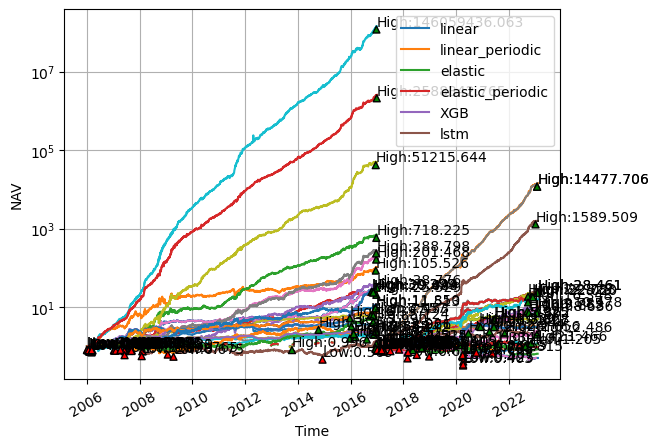

In [38]:
for p in ['D', 'W', 'M']:
    signal_res = pipeline.signal_result[p]

    in_daily_rets_df = pd.DataFrame()
    in_period_rets_df = pd.DataFrame()
    out_daily_rets_df = pd.DataFrame()
    out_period_rets_df = pd.DataFrame()
    
    for name, df in signal_res.items():
        in_daily_rets_df[name] = df[0][1]
        in_period_rets_df[name] = df[0][2]
        out_daily_rets_df[name] = df[1][1]
        out_period_rets_df[name] = df[1][2]

    ret_sum(in_daily_rets_df, f'{p} in sample daily return')
    ret_sum(in_period_rets_df, f'{p} in sample period return')
    ret_sum(out_daily_rets_df, f'{p} out sample daily return')
    ret_sum(out_period_rets_df, f'{p} out sample period return')
    
